### 環境変数(ERG_DATA_DIRもしくはSPEDAS_DATA_DIR)をpyspedasをimportする前に変更することで、データのダウンロード先を変更可能

In [1]:
import os
os.environ["SPEDAS_DATA_DIR"] = "/mnt/j/observation_data/"

## Artemyev先生の見つけたイベント: 2022/09/01

In [ ]:
import pyspedas as psp
import matplotlib as mpl
import pytplot as pt

pt.del_data('*')
mpl.rcdefaults()

time_range = ['20220901/01:00', '20220901/02:00']
psp.erg.mgf(trange=time_range, level='l2', datatype='64hz', coord='sm')
psp.erg.pwe_efd(trange=time_range, level='l2', datatype='spec')
psp.erg.lepe(trange=time_range, level='l2', datatype='omniflux')
psp.erg.orb(trange=time_range, level='l2', datatype='def')

In [ ]:
#pt.tplot_names()
pt.timespan('2022-09-01/01:30:00',30,keyword='minute')
pt.options('erg_lepe_l2_omniflux_FEDO', 'zrange', [1E2, 1E4])
pt.tplot(['erg_lepe_l2_omniflux_FEDO'])

08-Jul-25 00:22:32: del_data: No valid tplot variables found, returning
08-Jul-25 00:22:32: Downloading remote index: https://ergsc.isee.nagoya-u.ac.jp/data/ergsc/satellite/erg/mgf/l2/64hz/2022/09/
08-Jul-25 00:22:34: File is current: /mnt/j/observation_data//ergsc/satellite/erg/mgf/l2/64hz/2022/09/erg_mgf_l2_64hz_dsi_2022090103_v04.05.cdf
08-Jul-25 00:22:34: File is current: /mnt/j/observation_data//ergsc/satellite/erg/mgf/l2/64hz/2022/09/erg_mgf_l2_64hz_dsi_2022090104_v04.05.cdf


 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Magnetic Field Experiment (MGF) Level 2 64 Hz resolution magnetic field data']

Information about ERG MGF

PI:  ['Ayako Matsuoka']
Affiliation:  ['Data Analysis Center for Geomagnetism and Space Magnetism, Graduate School of Science, Kyoto University, Kitashirakawa-Oiwake Cho, Sakyo-ku Kyoto 606-8502, Japan']

RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en
RoR of MGF L2: https://ergsc.isee.nagoya-u.ac.jp/mw/index.php/ErgSat/Mgf
Contact: erg_mgf_info at isee.nagoya-u.ac.jp
**************************************************************************
mag_smoothed NaN 割合: 0.013884972911072843


08-Jul-25 00:24:11: /usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1048) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()



fac_projection 完全NaN 割合: 0.013884972911072843
0.013884972911072843
0.013884972911072843
0.013884972911072843
0.013884972911072843
0.013884972911072843
0.013884972911072843
0.013884972911072843
0.013884972911072843
0.013884972911072843
0.013884972911072843
0.013884972911072843
0.013884972911072843


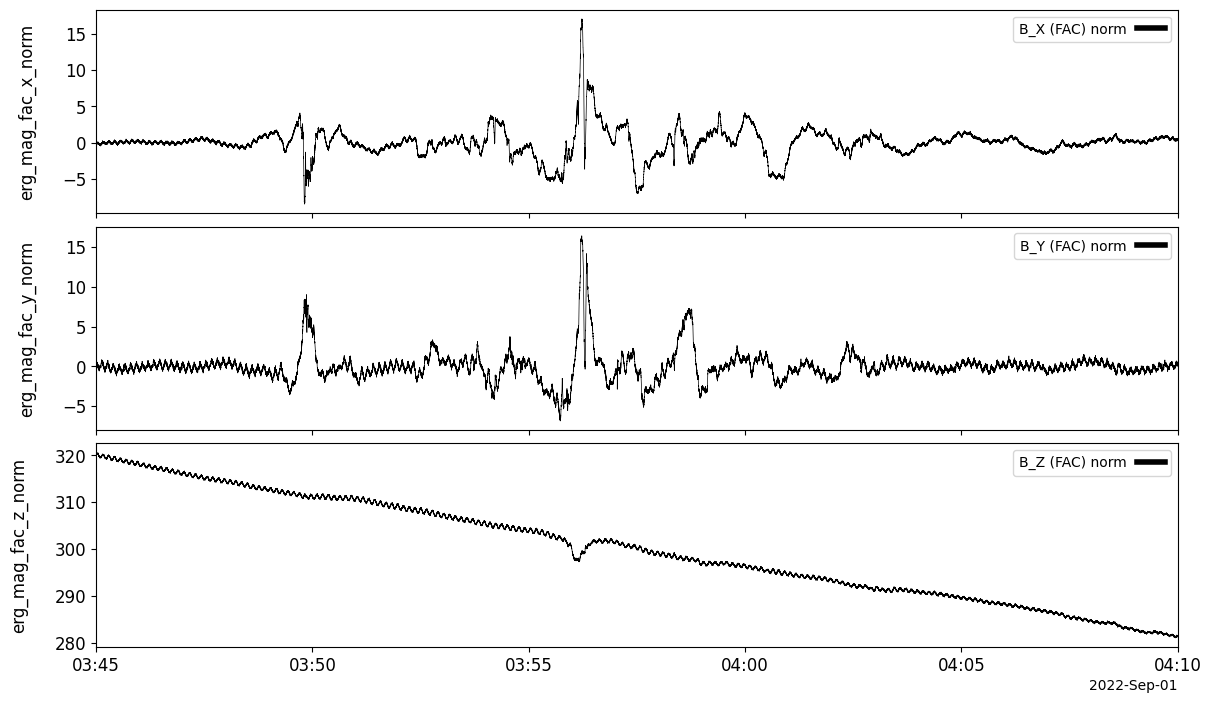

NaN 割合 = 0.013884972911072843


In [2]:
# --- 必要ライブラリ -------------------------------------------------------
import pyspedas as psp
from ergpyspedas.erg import mgf
import pytplot as pt
import numpy as np
import xarray as xr
from multiprocessing import Pool
import os
import pandas as pd

# --- 0. 既存 tplot 変数を全削除 -------------------------------------------
pt.del_data('*')
# --- 1. ERG/MGF データ取得 ----------------------------------------------
time_range = ['20220901/03:40:00', '20220901/04:15:00']
pt.timespan('2022-09-01/03:45:00', 25, keyword='minute')
mgf(time_range, level='l2', datatype='64hz', coord='dsi')
mag_raw = pt.data_quants['erg_mgf_l2_mag_64hz_dsi']     # dim=('time','v_dim')

# x, y, z 成分を個別に取り出す（tplot 変数はタプル形式なので注意）
psp.split_vec('erg_mgf_l2_mag_64hz_dsi')
mag_tplot_x = pt.get_data('erg_mgf_l2_mag_64hz_dsi_x')  # (times, values)
mag_tplot_y = pt.get_data('erg_mgf_l2_mag_64hz_dsi_y')
mag_tplot_z = pt.get_data('erg_mgf_l2_mag_64hz_dsi_z')

# --- 2. 移動平均（100 s） -------------------------------------------------
window_sec = 100
# サンプリング周期 [s] を推定（dt ≃ 1/64 s）
sample_period_sec = (
    np.diff(mag_raw['time'].values.astype('datetime64[ns]'))
    .astype(float).mean() * 1e-9
)
window_points = int(window_sec / sample_period_sec)

mag_smoothed = mag_raw.rolling(
    time=window_points, center=True
).mean('time')                                          # 同じ dims

nan_avg = np.isnan(mag_smoothed.values).any(axis=1)
print('mag_smoothed NaN 割合:', nan_avg.mean())

# --- 3. FAC 基底への射影を計算 -------------------------------------------
def fac_projection(
        b_avg_vec: xr.DataArray,
        bx_val: float,
        by_val: float,
        bz_val: float
    ):
    """
    b_avg_vec : 300 s 移動平均磁場（ベクトル, shape=(3,))
    bx_val, by_val, bz_val : 1 サンプルの各成分
    戻り値 :
        fac_components      : 射影後のベクトル (3,)
        fac_scalar_norms    : 各成分のスカラー射影量 (3,)
        fac_unit_vectors    : FAC 基底の単位ベクトル (3x3)
    """
    # 元座標系ベクトル
    original_vec = np.array([bx_val, by_val, bz_val])

    # FAC 基底を構成 -----------------------------------
    z0_global = np.array([0, 0, 1])             # 地球 Z 軸
    e2_fac = np.cross(b_avg_vec, z0_global)      # FAC y
    e1_fac = np.cross(e2_fac, b_avg_vec)         # FAC x
    e3_fac = b_avg_vec                           # FAC z

    # 単位ベクトル
    e1_hat = e1_fac / np.linalg.norm(e1_fac)
    e2_hat = e2_fac / np.linalg.norm(e2_fac)
    e3_hat = e3_fac / np.linalg.norm(e3_fac)

    # スカラー射影
    comp_e1 = np.dot(e1_hat, original_vec)
    comp_e2 = np.dot(e2_hat, original_vec)
    comp_e3 = np.dot(e3_hat, original_vec)

    # ベクトル射影
    vec_e1 = comp_e1 * e1_hat
    vec_e2 = comp_e2 * e2_hat
    vec_e3 = comp_e3 * e3_hat

    fac_components   = np.array([vec_e1, vec_e2, vec_e3])
    fac_scalar_norms = np.array([comp_e1, comp_e2, comp_e3])
    fac_unit_vectors = np.array([e1_hat, e2_hat, e3_hat])

    return fac_components, fac_scalar_norms, fac_unit_vectors

# マルチプロセッシング準備 ---------------------------------------------
n_cpu = os.cpu_count()
bx_values, bx_times = mag_tplot_x.y, mag_tplot_x.times
by_values            = mag_tplot_y.y
bz_values            = mag_tplot_z.y

# 出力用配列
n_samples = len(bx_times)
fac_vecs_x = np.zeros((n_samples, 3))
fac_vecs_y = np.zeros((n_samples, 3))
fac_vecs_z = np.zeros((n_samples, 3))
fac_norms  = np.zeros((n_samples, 3))             # (comp_x, comp_y, comp_z)
fac_e_hat  = np.zeros((n_samples, 3, 3))          # 3 unit vectors / sample

if __name__ == '__main__':
    with Pool(processes=n_cpu) as pool:
        iterator = zip(
            mag_smoothed.values,                 # 平均ベクトル
            bx_values, by_values, bz_values
        )
        results = pool.starmap(fac_projection, iterator)

    for idx, (vecs, norms, e_hat) in enumerate(results):
        fac_vecs_x[idx] = vecs[0]
        fac_vecs_y[idx] = vecs[1]
        fac_vecs_z[idx] = vecs[2]
        fac_norms[idx]  = norms
        fac_e_hat[idx]  = e_hat

bad = np.isnan(fac_norms).all(axis=1)       # 3成分とも NaN
print('fac_projection 完全NaN 割合:', bad.mean())

# --- 4. tplot 変数に登録 --------------------------------------------------
# 便利用ラベル
component_tags = ['x', 'y', 'z']
scalar_tags    = ['x', 'y', 'z', 'norm']
colors         = ['red', 'green', 'blue', 'black']

for i_comp, comp in enumerate(component_tags):
    # 各ベクトル成分
    comp_fac_list = [
        fac_vecs_x[:, i_comp],
        fac_vecs_y[:, i_comp],
        fac_vecs_z[:, i_comp],
        fac_norms[:, i_comp],
    ]
    for j, tag in enumerate(scalar_tags):
        varname = f'erg_mag_fac_{comp}_{tag}'
        pt.store_data(varname,
                      data={'x': bx_times, 'y': comp_fac_list[j]})
        print(np.isnan(fac_norms[:, 2]).mean())
        pt.options(varname, 'legend_names',
                   f'B_{comp.upper()} (FAC) {tag}')
        pt.options(varname, 'color', colors[j])

    # 3 成分＋normをまとめたグループ変数
    #pt.store_data(f'erg_mag_fac_{comp}',
    #              data=[f'erg_mag_fac_{comp}_x',
    #                    f'erg_mag_fac_{comp}_y',
    #                    f'erg_mag_fac_{comp}_z',
    #                    f'erg_mag_fac_{comp}_norm'])
    #pt.options(f'erg_mag_fac_{comp}',
    #           'ytitle', f'B_{comp} (FAC)\n[nT]')

# --- 5. プロット ---------------------------------------------------------
raw = pt.data_quants[f'erg_mag_fac_z_norm']

pt.tplot(['erg_mag_fac_x_norm',
          'erg_mag_fac_y_norm',
          'erg_mag_fac_z_norm'])

raw = pt.data_quants['erg_mag_fac_z_norm']
print('NaN 割合 =', np.isnan(raw.data).mean())

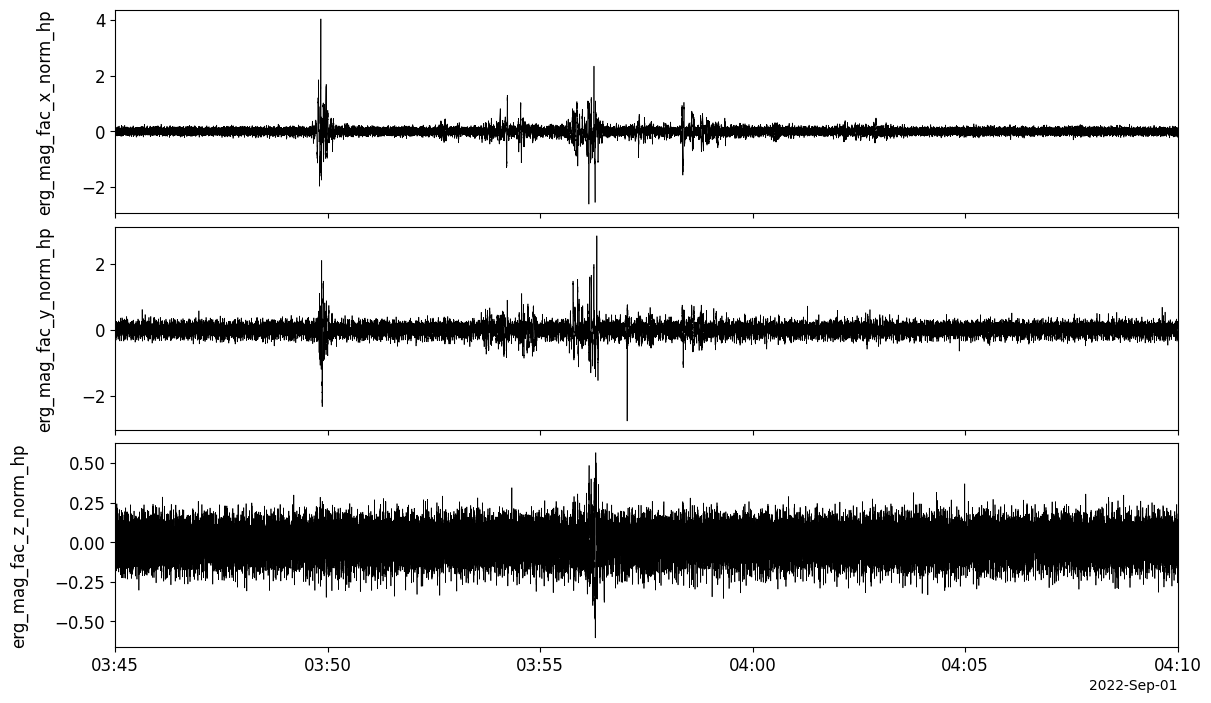

In [3]:
import numpy as np
from scipy.signal import butter, sosfiltfilt
import pytplot as pt

# Butterworth high pass filter (2poles x 2stage = 4次精度)
fs = 64.0   # サンプリング周波数
cutoff = 1/4    # spin周期 = 8 sec、少し上の周波数に設定
sos = butter(N=4, Wn=cutoff/(fs/2), btype='high', output='sos')

def highpass_segmented(y, sos):
    finite = np.isfinite(y)
    hp = np.full_like(y, np.nan)

    # 連続 True 区間のインデックスを抽出
    idx = np.where(finite)[0]
    segs = np.split(idx, np.where(np.diff(idx) != 1)[0] + 1)

    padlen = 3 * (sos.shape[0] - 1)    # sosfiltfilt が要求する長さ

    for s in segs:
        if len(s) <= padlen:            # 短すぎる区間はスキップ
            continue
        hp[s] = sosfiltfilt(sos, y[s])
    return hp

for comp in ['x', 'y', 'z']:
    da   = pt.data_quants[f'erg_mag_fac_{comp}_norm']
    hp   = highpass_segmented(da.data, sos)
    pt.store_data(f'erg_mag_fac_{comp}_norm_hp',
                  data={'x': da.time.values, 'y': hp})

pt.tplot(['erg_mag_fac_x_norm_hp',
          'erg_mag_fac_y_norm_hp',
          'erg_mag_fac_z_norm_hp'])

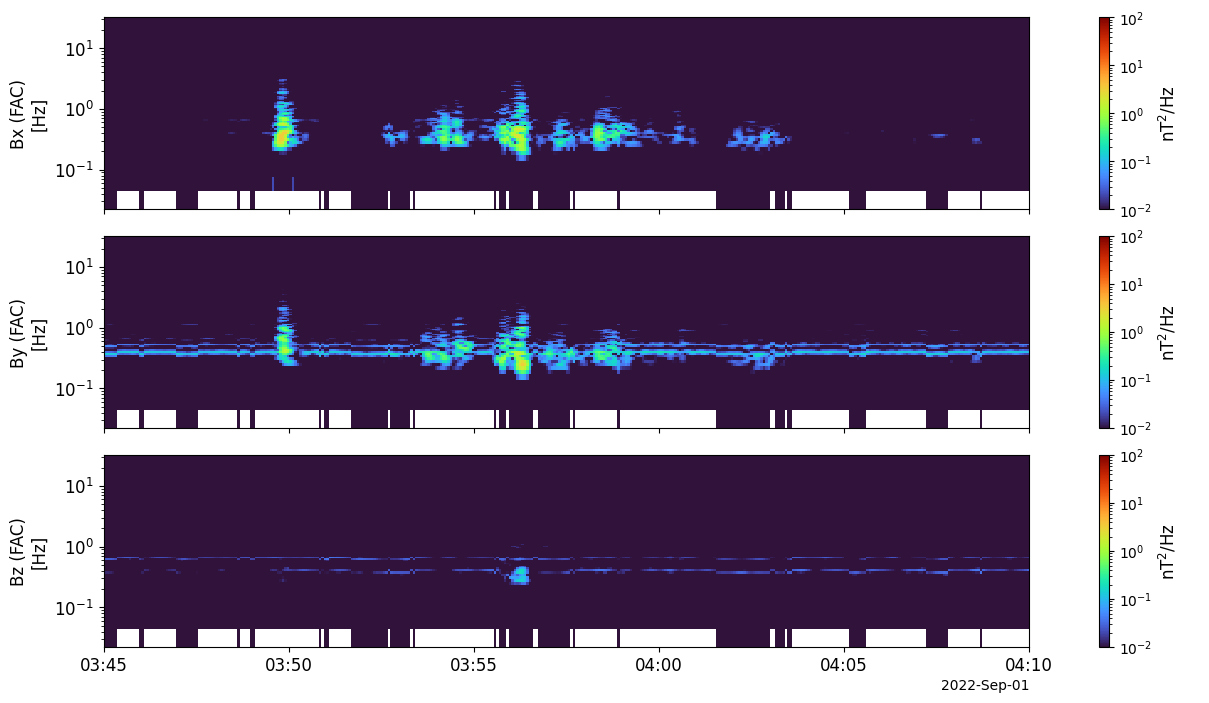

In [4]:
import pytplot as pt

# --- 6. FFT（パワースペクトル密度） -----------------------------------
# FFT 窓長 nfft = 1024 → 1024/64 ≈ 16 s
# overlap = 50%（デフォルト）／boxcar 平滑なし
nbox = 1024 * 2
nshift = nbox // 8

for comp in ['x', 'y', 'z']:
    var_in  = f'erg_mag_fac_{comp}_norm_hp'
    psp.tdpwrspc(var_in, nboxpoints=nbox, nshiftpoints=nshift, bin=1)

# --- 7. スペクトルをプロット --------------------------------------------
# カラーマップはデフォルトで log10(power) [nT²/Hz]
pt.options(['erg_mag_fac_x_norm_hp_dpwrspc',
          'erg_mag_fac_y_norm_hp_dpwrspc',
          'erg_mag_fac_z_norm_hp_dpwrspc'], 'ylog', 1)
#pt.options(['erg_mag_fac_x_norm_hp_dpwrspc',
#          'erg_mag_fac_y_norm_hp_dpwrspc',
#          'erg_mag_fac_z_norm_hp_dpwrspc'], 'yrange', [0, 1])
pt.options(['erg_mag_fac_x_norm_hp_dpwrspc',
          'erg_mag_fac_y_norm_hp_dpwrspc',
          'erg_mag_fac_z_norm_hp_dpwrspc'], 'zrange', [1E-2, 1E2])
pt.options(['erg_mag_fac_x_norm_hp_dpwrspc',
          'erg_mag_fac_y_norm_hp_dpwrspc',
          'erg_mag_fac_z_norm_hp_dpwrspc'], 'zrange', [1E-2, 1E2])
pt.options(['erg_mag_fac_x_norm_hp_dpwrspc',
          'erg_mag_fac_y_norm_hp_dpwrspc',
          'erg_mag_fac_z_norm_hp_dpwrspc'], 'colormap', 'turbo')
pt.options('erg_mag_fac_x_norm_hp_dpwrspc', 'ytitle', 'Bx (FAC)')
pt.options('erg_mag_fac_y_norm_hp_dpwrspc', 'ytitle', 'By (FAC)')
pt.options('erg_mag_fac_z_norm_hp_dpwrspc', 'ytitle', 'Bz (FAC)')
pt.options(['erg_mag_fac_x_norm_hp_dpwrspc',
          'erg_mag_fac_y_norm_hp_dpwrspc',
          'erg_mag_fac_z_norm_hp_dpwrspc'], 'ztitle', 'nT^2/Hz')

pt.tplot(['erg_mag_fac_x_norm_hp_dpwrspc',
          'erg_mag_fac_y_norm_hp_dpwrspc',
          'erg_mag_fac_z_norm_hp_dpwrspc'])

# LEP-e

### Energy channel
[ nan, 67.03717, 180.5792, 425.59097, 963.4217, 2152.625, 4770.068, 10536.809, nan, 114.844345, 276.19354, 640.7232, 1441.4934, 3204.3828, 7088.716, 15652.176, nan, 90.94076, 222.41048, 521.20526, 1178.554, 2624.7207, 5815.8496, 12843.505, nan, 144.72382, 341.9284, 790.12067, 1764.1918, 3909.5388, 8642.449, 19076.365]

### Energy Sort
[ 67.03717, 90.94076, 114.844345, 144.72382, 180.5792, 222.41048, 276.19354, 341.9284, 425.59097, 521.20526, 640.7232, 790.12067, 963.4217, 1178.554, 1441.4934, 1764.1918, 2152.625, 2624.7207, 3204.3828, 3909.5388, 4770.068, 5815.8496, 7088.716, 8642.449, 10536.809, 12843.505, 15652.176, 19076.365, nan, nan, nan, nan]

08-Jul-25 00:14:09: Downloading remote index: https://ergsc.isee.nagoya-u.ac.jp/data/ergsc/satellite/erg/pwe/efd/l2/spec/2022/09/
08-Jul-25 00:14:09: File is current: /mnt/j/observation_data//ergsc/satellite/erg/pwe/efd/l2/spec/2022/09/erg_pwe_efd_l2_spec_20220901_v02_03.cdf
08-Jul-25 00:14:09: Downloading remote index: https://ergsc.isee.nagoya-u.ac.jp/data/ergsc/satellite/erg/lepe/l2/3dflux/2022/09/
08-Jul-25 00:14:10: File is current: /mnt/j/observation_data//ergsc/satellite/erg/lepe/l2/3dflux/2022/09/erg_lepe_l2_3dflux_20220901_v04_01.cdf


 
 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Plasma Wave Experiment (PWE) Electric Field Data (EFD) Level 2 spectrum data']

Information about ERG PWE EFD

PI:  ['Yoshiya Kasahara']
Affiliation:  ['Kanazawa University']

RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en
RoR of PWE/EFD: https://ergsc.isee.nagoya-u.ac.jp/mw/index.php/ErgSat/Pwe/Efd

Contact: erg_pwe_info at isee.nagoya-u.ac.jp
**************************************************************************


08-Jul-25 00:14:15: Variable FEDU DEPEND_1 attribute FEDU_Energy has too many dimensions (3). Keeping extra dimensions (for now).
08-Jul-25 00:14:15: Variable Count_Rate DEPEND_1 attribute FEDU_Energy has too many dimensions (3). Keeping extra dimensions (for now).
08-Jul-25 00:14:15: Variable Count_Rate_BG DEPEND_1 attribute FEDU_Energy has too many dimensions (3). Keeping extra dimensions (for now).
08-Jul-25 00:14:18: erg_lepe_l2_3dflux_FEDU contains negative values; setting the z-axis to log scale will cause the negative values to be ignored on figures.
08-Jul-25 00:14:18: Downloading remote index: https://ergsc.isee.nagoya-u.ac.jp/data/ergsc/satellite/erg/mgf/l2/64hz/2022/09/


 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Low-Energy Particle experiments - electron analyzer (LEP-e) Level 2 3D electron flux data']

Information about ERG LEPe

PI:  ['Shiang-Yu Wang']
Affiliation:  ['Academia Sinica, Taiwan']

RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en
RoR of LEPe L2: https://ergsc.isee.nagoya-u.ac.jp/mw/index.php/ErgSat/Lepe

Contact: erg_lepe_info at isee.nagoya-u.ac.jp
**************************************************************************


08-Jul-25 00:14:20: File is current: /mnt/j/observation_data//ergsc/satellite/erg/mgf/l2/64hz/2022/09/erg_mgf_l2_64hz_dsi_2022090103_v04.05.cdf
08-Jul-25 00:14:20: File is current: /mnt/j/observation_data//ergsc/satellite/erg/mgf/l2/64hz/2022/09/erg_mgf_l2_64hz_dsi_2022090104_v04.05.cdf
08-Jul-25 00:14:21: Downloading remote index: https://ergsc.isee.nagoya-u.ac.jp/data/ergsc/satellite/erg/orb/def/2022/


 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Magnetic Field Experiment (MGF) Level 2 64 Hz resolution magnetic field data']

Information about ERG MGF

PI:  ['Ayako Matsuoka']
Affiliation:  ['Data Analysis Center for Geomagnetism and Space Magnetism, Graduate School of Science, Kyoto University, Kitashirakawa-Oiwake Cho, Sakyo-ku Kyoto 606-8502, Japan']

RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en
RoR of MGF L2: https://ergsc.isee.nagoya-u.ac.jp/mw/index.php/ErgSat/Mgf
Contact: erg_mgf_info at isee.nagoya-u.ac.jp
**************************************************************************


08-Jul-25 00:14:21: File is current: /mnt/j/observation_data//ergsc/satellite/erg/orb/def/2022/erg_orb_l2_20220901_v05.cdf


 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************


08-Jul-25 00:14:24: /home/satanka/Documents/observation_workspace/.venv_pyspedas/lib/python3.12/site-packages/pyspedas/projects/erg/satellite/erg/particle/erg_pgs_make_e_spec.py:30: RuntimeWarning: invalid value encountered in divide
  ave = data_array.sum(axis=1) / data['bins'].sum(axis=1)



0 : erg_pwe_efd_l2_spec_spectra
1 : erg_pwe_efd_l2_spec_quality_flag
2 : erg_lepe_l2_3dflux_FEDU
3 : erg_mgf_l2_epoch_64hz
4 : erg_mgf_l2_date_time_64hz
5 : erg_mgf_l2_mag_64hz_dsi
6 : erg_mgf_l2_dyn_rng_64hz
7 : erg_mgf_l2_quality_64hz
8 : erg_mgf_l2_quality_64hz_gc
9 : erg_mgf_l2_spin_phase_64hz
10 : erg_mgf_l2_ti_64hz
11 : erg_orb_l2_pos_llr
12 : erg_orb_l2_pos_gse
13 : erg_orb_l2_pos_gsm
14 : erg_orb_l2_pos_sm
15 : erg_orb_l2_pos_rmlatmlt
16 : erg_orb_l2_pos_eq
17 : erg_orb_l2_pos_iono_north
18 : erg_orb_l2_pos_iono_south
19 : erg_orb_l2_pos_blocal
20 : erg_orb_l2_pos_blocal_mag
21 : erg_orb_l2_pos_beq
22 : erg_orb_l2_pos_beq_mag
23 : erg_orb_l2_pos_Lm
24 : erg_orb_l2_vel_gse
25 : erg_orb_l2_vel_gsm
26 : erg_orb_l2_vel_sm
27 : erg_orb_l2_spn_num
28 : erg_orb_l2_man_prep_flag
29 : erg_orb_l2_man_on_flag
30 : erg_orb_l2_eclipse_flag
31 : erg_lepe_l2_3dflux_FEDU_energy


08-Jul-25 00:14:27: erg_mgf_l2_mag_64hz_dsi copied to erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:14:27: tinterpol (linear) was applied to: erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:14:27: erg_orb_l2_pos_gse copied to erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:14:27: tinterpol (linear) was applied to: erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:14:27: erg_orb_l2_pos_gse_pgs_temp copied to pos_pgs_temp
08-Jul-25 00:14:27: ['gse', 'gsm', 'sm']
08-Jul-25 00:14:27: Running transformation: subgse2gsm
08-Jul-25 00:14:27: Running transformation: subgsm2sm
08-Jul-25 00:14:27: Setting coordinate system for pos_pgs_temp
08-Jul-25 00:14:27: Output variable: pos_pgs_temp
08-Jul-25 00:14:27: ['sm', 'gsm', 'gse', 'gei', 'j2000']
08-Jul-25 00:14:27: Running transformation: subsm2gsm
08-Jul-25 00:14:27: Running transformation: subgsm2gse
08-Jul-25 00:14:27: Running transformation: subgse2gei
08-Jul-25 00:14:27: Running transformation: subgei2j2000
08-Jul-25 00:14:27: Setting coordinate system for phi

 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************
J2000 --> DSI


08-Jul-25 00:14:31: erg_mgf_l2_mag_64hz_dsi copied to erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:14:32: tinterpol (linear) was applied to: erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:14:32: erg_orb_l2_pos_gse copied to erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:14:32: tinterpol (linear) was applied to: erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:14:32: erg_orb_l2_pos_gse_pgs_temp copied to pos_pgs_temp
08-Jul-25 00:14:32: ['gse', 'gsm', 'sm']
08-Jul-25 00:14:32: Running transformation: subgse2gsm
08-Jul-25 00:14:32: Running transformation: subgsm2sm
08-Jul-25 00:14:32: Setting coordinate system for pos_pgs_temp
08-Jul-25 00:14:32: Output variable: pos_pgs_temp
08-Jul-25 00:14:32: ['sm', 'gsm', 'gse', 'gei', 'j2000']
08-Jul-25 00:14:32: Running transformation: subsm2gsm
08-Jul-25 00:14:32: Running transformation: subgsm2gse
08-Jul-25 00:14:32: Running transformation: subgse2gei
08-Jul-25 00:14:32: Running transformation: subgei2j2000
08-Jul-25 00:14:32: Setting coordinate system for phi

 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************
J2000 --> DSI


08-Jul-25 00:14:35: erg_mgf_l2_mag_64hz_dsi copied to erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:14:35: tinterpol (linear) was applied to: erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:14:35: erg_orb_l2_pos_gse copied to erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:14:35: tinterpol (linear) was applied to: erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:14:35: erg_orb_l2_pos_gse_pgs_temp copied to pos_pgs_temp
08-Jul-25 00:14:35: ['gse', 'gsm', 'sm']
08-Jul-25 00:14:35: Running transformation: subgse2gsm
08-Jul-25 00:14:35: Running transformation: subgsm2sm
08-Jul-25 00:14:35: Setting coordinate system for pos_pgs_temp
08-Jul-25 00:14:35: Output variable: pos_pgs_temp
08-Jul-25 00:14:35: ['sm', 'gsm', 'gse', 'gei', 'j2000']
08-Jul-25 00:14:35: Running transformation: subsm2gsm
08-Jul-25 00:14:35: Running transformation: subgsm2gse
08-Jul-25 00:14:35: Running transformation: subgse2gei
08-Jul-25 00:14:35: Running transformation: subgei2j2000
08-Jul-25 00:14:35: Setting coordinate system for phi

 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************
J2000 --> DSI


08-Jul-25 00:14:36: Unknown option supplied: vertical_spacing
08-Jul-25 00:14:36: Unrecognized option ytitle_offset
08-Jul-25 00:14:36: Unrecognized option ytitle_offset
08-Jul-25 00:14:36: Unrecognized option ytitle_offset
08-Jul-25 00:14:36: Unrecognized option ytitle_offset
08-Jul-25 00:14:36: Unrecognized option ytitle_offset


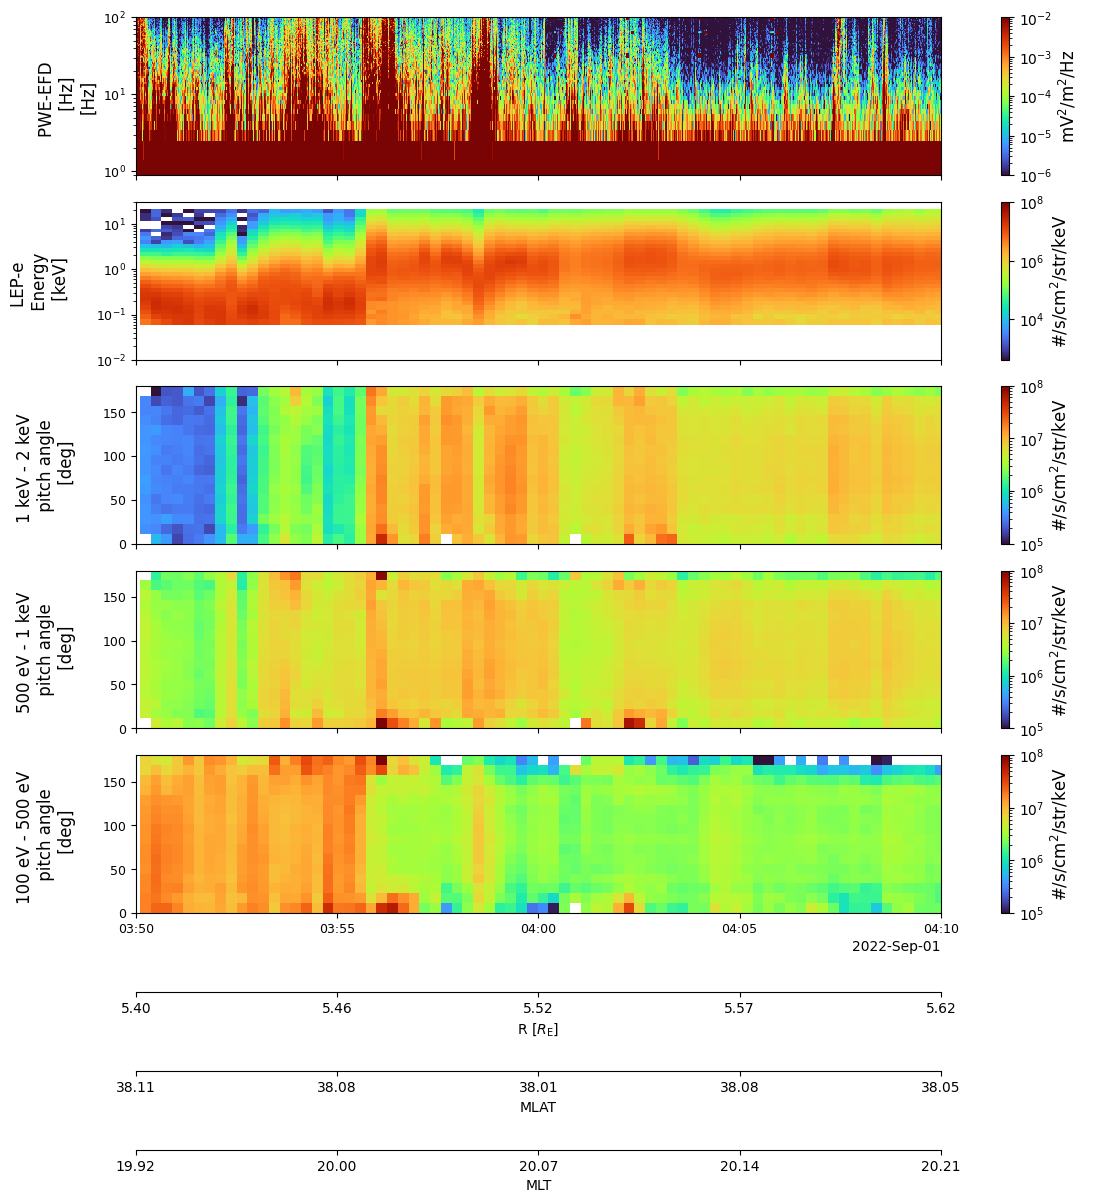

In [46]:
import pytplot as pt
import pyspedas as psp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

# データのリセット
pt.del_data('*')
pt.timespan('2022-09-01/03:50:00',20,keyword='minute')
mpl.rcdefaults()

# データのダウンロード
trange_download = ['20220901/03:45:00', '20220901/04:15:00']
trange = trange_download
psp.erg.pwe_efd(trange_download, level='l2', datatype='spec')
psp.erg.lepe(trange_download, level='l2', datatype='3dflux')
psp.erg.mgf(trange_download, level='l2', datatype='64hz', coord='dsi')
psp.erg.orb(trange_download, level='l2', datatype='def')

# energyデータの作成
psp.erg.erg_lep_part_products('erg_lepe_l2_3dflux_FEDU', outputs='energy', mag_name='erg_mgf_l2_mag_64hz_dsi', pos_name='erg_orb_l2_pos_gse', trange=trange)
pt.tplot_names()
energy_flux = pt.data_quants['erg_lepe_l2_3dflux_FEDU_energy']

# pitch angleデータの作成
psp.erg.erg_lep_part_products('erg_lepe_l2_3dflux_FEDU', outputs='pa', energy=[1000, 2000], mag_name='erg_mgf_l2_mag_64hz_dsi', pos_name='erg_orb_l2_pos_gse', trange=trange, suffix='_1-2keV')
energy_flux_pa_10_20 = pt.data_quants['erg_lepe_l2_3dflux_FEDU_pa_1-2keV']
psp.erg.erg_lep_part_products('erg_lepe_l2_3dflux_FEDU', outputs='pa', energy=[500, 1000], mag_name='erg_mgf_l2_mag_64hz_dsi', pos_name='erg_orb_l2_pos_gse', trange=trange, suffix='_500-1000eV')
energy_flux_pa_5_10 = pt.data_quants['erg_lepe_l2_3dflux_FEDU_pa_500-1000eV']
psp.erg.erg_lep_part_products('erg_lepe_l2_3dflux_FEDU', outputs='pa', energy=[100, 500], mag_name='erg_mgf_l2_mag_64hz_dsi', pos_name='erg_orb_l2_pos_gse', trange=trange, suffix='_100-500eV')
energy_flux_pa_1_5 = pt.data_quants['erg_lepe_l2_3dflux_FEDU_pa_100-500eV']

#orbitデータの作成
orb_labels = pt.split_vec('erg_orb_l2_pos_rmlatmlt')

pt.options(orb_labels[0], 'ytitle', r'R [$R_{\mathrm{E}}$]')
pt.options(orb_labels[1], 'ytitle', 'MLAT')
pt.options(orb_labels[2], 'ytitle', 'MLT')


pt.store_data('erg_lepe_l2_3dflux_FEDU_energy_keV', data={'x': energy_flux.time, 'y': energy_flux.data*1E3, 'v': energy_flux.spec_bins*1E-3}, attr_dict=energy_flux.attrs)
pt.store_data('erg_lepe_l2_3dflux_FEDU_pa_1-2keV', data={'x': energy_flux_pa_10_20.time, 'y': energy_flux_pa_10_20.data*1E3, 'v': energy_flux_pa_10_20.spec_bins}, attr_dict=energy_flux_pa_10_20.attrs)
pt.store_data('erg_lepe_l2_3dflux_FEDU_pa_500-1000eV', data={'x': energy_flux_pa_5_10.time, 'y': energy_flux_pa_5_10.data*1E3, 'v': energy_flux_pa_5_10.spec_bins}, attr_dict=energy_flux_pa_5_10.attrs)
pt.store_data('erg_lepe_l2_3dflux_FEDU_pa_100-500eV', data={'x': energy_flux_pa_1_5.time, 'y': energy_flux_pa_1_5.data*1E3, 'v': energy_flux_pa_1_5.spec_bins}, attr_dict=energy_flux_pa_1_5.attrs)
pt.options('erg_lepe_l2_3dflux_FEDU_energy_keV', 'ytitle', 'LEP-e \n Energy \n [keV]')
pt.options('erg_lepe_l2_3dflux_FEDU_pa_1-2keV', 'ytitle', '1 keV - 2 keV \n pitch angle \n [deg]')
pt.options('erg_lepe_l2_3dflux_FEDU_pa_500-1000eV', 'ytitle', '500 eV - 1 keV \n pitch angle \n [deg]')
pt.options('erg_lepe_l2_3dflux_FEDU_pa_100-500eV', 'ytitle', '100 eV - 500 eV \n pitch angle \n [deg]')
pt.options('erg_pwe_efd_l2_spec_spectra', 'ytitle', 'PWE-EFD \n [Hz]')
pt.options('erg_lepe_l2_3dflux_FEDU_energy_keV', 'yrange', [0.01, 30])
pt.options('erg_lepe_l2_3dflux_FEDU_energy_keV', 'ylog', 1)
pt.options('erg_lepe_l2_3dflux_FEDU_energy_keV', 'zrange', [4E2, 1E8])
pt.options(['erg_pwe_efd_l2_spec_spectra', 'erg_lepe_l2_3dflux_FEDU_energy_keV', 'erg_lepe_l2_3dflux_FEDU_pa_1-2keV', 'erg_lepe_l2_3dflux_FEDU_pa_500-1000eV', 'erg_lepe_l2_3dflux_FEDU_pa_100-500eV'], 'colormap', 'turbo')
pt.options(['erg_lepe_l2_3dflux_FEDU_pa_1-2keV', 'erg_lepe_l2_3dflux_FEDU_pa_500-1000eV', 'erg_lepe_l2_3dflux_FEDU_pa_100-500eV'], 'zrange', [1E5, 1E8])
pt.options(['erg_lepe_l2_3dflux_FEDU_energy_keV', 'erg_lepe_l2_3dflux_FEDU_pa_1-2keV', 'erg_lepe_l2_3dflux_FEDU_pa_500-1000eV', 'erg_lepe_l2_3dflux_FEDU_pa_100-500eV'], 'ztitle', '#/s/cm^2/str/keV')
pt.options('erg_pwe_efd_l2_spec_spectra', 'ztitle', 'mV^2/m^2/Hz')

bottom_vars = orb_labels

# パネル枚数から欲しい縦寸法を決める例
panels      = ['erg_pwe_efd_l2_spec_spectra',
               'erg_lepe_l2_3dflux_FEDU_energy_keV',
               'erg_lepe_l2_3dflux_FEDU_pa_1-2keV',
               'erg_lepe_l2_3dflux_FEDU_pa_500-1000eV',
               'erg_lepe_l2_3dflux_FEDU_pa_100-500eV']
panel_num   = len(panels)           # 5
bottom_num  = len(orb_labels)       # R, MLAT, MLT の 3 本
inch_per_pan = 1.5                  # 1 枚あたり 2.4 inch 高

# --- まずサイズとフォントを一括指定 ---
pt.tplot_options('xsize', 11)                                    # 横幅 11 inch
pt.tplot_options('ysize', inch_per_pan*(panel_num+bottom_num))   # 計算した縦幅
pt.tplot_options('axis_font_size', 9)                            # 文字を少し小さく
pt.tplot_options('vertical_spacing', 60)                         # パネル間 60 px

# --- ラベル衝突が気になる変数だけ個別にオフセット ---
for v in panels:
    pt.options(v, 'ytitle_offset', 70)   # y 軸ラベルを少し右へ:contentReference[oaicite:2]{index=2}

# --- 描画 ---
pt.tplot(panels, var_label=orb_labels)

#fig = pt.tplot(
#    ['erg_pwe_efd_l2_spec_spectra',
#    'erg_lepe_l2_3dflux_FEDU_energy_keV',
#    'erg_lepe_l2_3dflux_FEDU_pa_1-2keV',
#    'erg_lepe_l2_3dflux_FEDU_pa_500-1000eV',
#    'erg_lepe_l2_3dflux_FEDU_pa_100-500eV'],
#    var_label=bottom_vars
#)

# ピッチ角分布をplotする

08-Jul-25 00:36:52: Downloading remote index: https://ergsc.isee.nagoya-u.ac.jp/data/ergsc/satellite/erg/lepe/l2/3dflux/2022/09/
08-Jul-25 00:36:52: File is current: /mnt/j/observation_data//ergsc/satellite/erg/lepe/l2/3dflux/2022/09/erg_lepe_l2_3dflux_20220901_v04_01.cdf
08-Jul-25 00:36:58: Variable FEDU DEPEND_1 attribute FEDU_Energy has too many dimensions (3). Keeping extra dimensions (for now).
08-Jul-25 00:36:58: Variable Count_Rate DEPEND_1 attribute FEDU_Energy has too many dimensions (3). Keeping extra dimensions (for now).
08-Jul-25 00:36:58: Variable Count_Rate_BG DEPEND_1 attribute FEDU_Energy has too many dimensions (3). Keeping extra dimensions (for now).
08-Jul-25 00:37:01: erg_lepe_l2_3dflux_FEDU contains negative values; setting the z-axis to log scale will cause the negative values to be ignored on figures.
08-Jul-25 00:37:01: Downloading remote index: https://ergsc.isee.nagoya-u.ac.jp/data/ergsc/satellite/erg/mgf/l2/64hz/2022/09/


 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Low-Energy Particle experiments - electron analyzer (LEP-e) Level 2 3D electron flux data']

Information about ERG LEPe

PI:  ['Shiang-Yu Wang']
Affiliation:  ['Academia Sinica, Taiwan']

RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en
RoR of LEPe L2: https://ergsc.isee.nagoya-u.ac.jp/mw/index.php/ErgSat/Lepe

Contact: erg_lepe_info at isee.nagoya-u.ac.jp
**************************************************************************


08-Jul-25 00:37:03: File is current: /mnt/j/observation_data//ergsc/satellite/erg/mgf/l2/64hz/2022/09/erg_mgf_l2_64hz_dsi_2022090103_v04.05.cdf
08-Jul-25 00:37:04: Downloading remote index: https://ergsc.isee.nagoya-u.ac.jp/data/ergsc/satellite/erg/orb/def/2022/


 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Magnetic Field Experiment (MGF) Level 2 64 Hz resolution magnetic field data']

Information about ERG MGF

PI:  ['Ayako Matsuoka']
Affiliation:  ['Data Analysis Center for Geomagnetism and Space Magnetism, Graduate School of Science, Kyoto University, Kitashirakawa-Oiwake Cho, Sakyo-ku Kyoto 606-8502, Japan']

RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en
RoR of MGF L2: https://ergsc.isee.nagoya-u.ac.jp/mw/index.php/ErgSat/Mgf
Contact: erg_mgf_info at isee.nagoya-u.ac.jp
**************************************************************************


08-Jul-25 00:37:04: File is current: /mnt/j/observation_data//ergsc/satellite/erg/orb/def/2022/erg_orb_l2_20220901_v05.cdf


 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************
nan
67.03717


08-Jul-25 00:37:07: erg_mgf_l2_mag_64hz_dsi copied to erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:37:07: tinterpol (linear) was applied to: erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:37:07: erg_orb_l2_pos_gse copied to erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:37:07: tinterpol (linear) was applied to: erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:37:07: erg_orb_l2_pos_gse_pgs_temp copied to pos_pgs_temp
08-Jul-25 00:37:07: ['gse', 'gsm', 'sm']
08-Jul-25 00:37:07: Running transformation: subgse2gsm
08-Jul-25 00:37:07: Running transformation: subgsm2sm
08-Jul-25 00:37:07: Setting coordinate system for pos_pgs_temp
08-Jul-25 00:37:07: Output variable: pos_pgs_temp
08-Jul-25 00:37:07: ['sm', 'gsm', 'gse', 'gei', 'j2000']
08-Jul-25 00:37:07: Running transformation: subsm2gsm
08-Jul-25 00:37:07: Running transformation: subgsm2gse
08-Jul-25 00:37:07: Running transformation: subgse2gei
08-Jul-25 00:37:07: Running transformation: subgei2j2000
08-Jul-25 00:37:07: Setting coordinate system for phi

 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************
J2000 --> DSI
[  5.625  16.875  28.125  39.375  50.625  61.875  73.125  84.375  95.625
 106.875 118.125 129.375 140.625 151.875 163.125 174.375]

<xarray.DataArray 'erg_lepe_l2_3dflux_FEDU_pa_PA' (v_dim: 16)> Size: 128B
array([     0.        , 464644.57894278, 244947.87964042, 225199.18095289,
       119814.71143929,  91986.98626155, 113263.16190118, 179373.90676664,
       222936.56188607,  88861.49275666, 160638.62155367, 187899.93501423,
       372919.98853928, 133381.0969371 , 215847.72481163,      0.        ])
Coordinates:
    time       datetime64[ns] 8B 2022-09-01T03:56:54.7574

08-Jul-25 00:37:11: erg_mgf_l2_mag_64hz_dsi copied to erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:37:11: tinterpol (linear) was applied to: erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:37:11: erg_orb_l2_pos_gse copied to erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:37:11: tinterpol (linear) was applied to: erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:37:11: erg_orb_l2_pos_gse_pgs_temp copied to pos_pgs_temp
08-Jul-25 00:37:11: ['gse', 'gsm', 'sm']
08-Jul-25 00:37:11: Running transformation: subgse2gsm
08-Jul-25 00:37:11: Running transformation: subgsm2sm
08-Jul-25 00:37:11: Setting coordinate system for pos_pgs_temp
08-Jul-25 00:37:11: Output variable: pos_pgs_temp
08-Jul-25 00:37:11: ['sm', 'gsm', 'gse', 'gei', 'j2000']
08-Jul-25 00:37:11: Running transformation: subsm2gsm
08-Jul-25 00:37:11: Running transformation: subgsm2gse
08-Jul-25 00:37:11: Running transformation: subgse2gei
08-Jul-25 00:37:11: Running transformation: subgei2j2000
08-Jul-25 00:37:11: Setting coordinate system for phi

 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************
J2000 --> DSI
[  5.625  16.875  28.125  39.375  50.625  61.875  73.125  84.375  95.625
 106.875 118.125 129.375 140.625 151.875 163.125 174.375]

<xarray.DataArray 'erg_lepe_l2_3dflux_FEDU_pa_PA' (v_dim: 16)> Size: 128B
array([      0.        , 2001148.28644168,  324665.51800305,
        623869.63429715,  381036.46974291,  439276.74237322,
        464606.501145  ,  438857.34543374,  489684.08389514,
        405477.04351812,  448906.7803295 ,  511662.63495562,
        668163.86754354,  510388.96969949, 2165039.95175877,
             0.        ])
Coordinates:
    time       datetime64[n

08-Jul-25 00:37:14: erg_mgf_l2_mag_64hz_dsi copied to erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:37:14: tinterpol (linear) was applied to: erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:37:14: erg_orb_l2_pos_gse copied to erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:37:14: tinterpol (linear) was applied to: erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:37:14: erg_orb_l2_pos_gse_pgs_temp copied to pos_pgs_temp
08-Jul-25 00:37:14: ['gse', 'gsm', 'sm']
08-Jul-25 00:37:14: Running transformation: subgse2gsm
08-Jul-25 00:37:14: Running transformation: subgsm2sm
08-Jul-25 00:37:14: Setting coordinate system for pos_pgs_temp
08-Jul-25 00:37:14: Output variable: pos_pgs_temp
08-Jul-25 00:37:14: ['sm', 'gsm', 'gse', 'gei', 'j2000']
08-Jul-25 00:37:14: Running transformation: subsm2gsm
08-Jul-25 00:37:14: Running transformation: subgsm2gse
08-Jul-25 00:37:14: Running transformation: subgse2gei
08-Jul-25 00:37:14: Running transformation: subgei2j2000
08-Jul-25 00:37:14: Setting coordinate system for phi

 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************
J2000 --> DSI
[  5.625  16.875  28.125  39.375  50.625  61.875  73.125  84.375  95.625
 106.875 118.125 129.375 140.625 151.875 163.125 174.375]

<xarray.DataArray 'erg_lepe_l2_3dflux_FEDU_pa_PA' (v_dim: 16)> Size: 128B
array([      0.        , 6077857.20289916, 2758057.8854879 ,
       2222096.91767931, 2031110.26708506, 2164316.29324913,
       2171736.70460671, 2049791.17553666, 2155911.28715053,
       2063927.11320296, 2132266.25899158, 1921127.00303651,
       2407730.43181755, 1998732.10384987, 4346699.83765349,
             0.        ])
Coordinates:
    time       datetime64[n

08-Jul-25 00:37:17: erg_mgf_l2_mag_64hz_dsi copied to erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:37:17: tinterpol (linear) was applied to: erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:37:17: erg_orb_l2_pos_gse copied to erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:37:17: tinterpol (linear) was applied to: erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:37:17: erg_orb_l2_pos_gse_pgs_temp copied to pos_pgs_temp
08-Jul-25 00:37:17: ['gse', 'gsm', 'sm']
08-Jul-25 00:37:17: Running transformation: subgse2gsm
08-Jul-25 00:37:17: Running transformation: subgsm2sm
08-Jul-25 00:37:17: Setting coordinate system for pos_pgs_temp
08-Jul-25 00:37:17: Output variable: pos_pgs_temp
08-Jul-25 00:37:17: ['sm', 'gsm', 'gse', 'gei', 'j2000']
08-Jul-25 00:37:17: Running transformation: subsm2gsm
08-Jul-25 00:37:17: Running transformation: subgsm2gse
08-Jul-25 00:37:17: Running transformation: subgse2gei
08-Jul-25 00:37:17: Running transformation: subgei2j2000
08-Jul-25 00:37:17: Setting coordinate system for phi

 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************
J2000 --> DSI
[  5.625  16.875  28.125  39.375  50.625  61.875  73.125  84.375  95.625
 106.875 118.125 129.375 140.625 151.875 163.125 174.375]

<xarray.DataArray 'erg_lepe_l2_3dflux_FEDU_pa_PA' (v_dim: 16)> Size: 128B
array([      0.        , 7487542.62667277, 8679530.94034106,
       9016410.5280785 , 8219884.70915776, 9589481.78749394,
       9035878.42031354, 8397568.27072459, 8294931.87192696,
       8063079.36122847, 8527698.88055956, 7999231.03478605,
       8284632.48007035, 8096171.57916695, 7639126.30429932,
             0.        ])
Coordinates:
    time       datetime64[n

08-Jul-25 00:37:21: erg_mgf_l2_mag_64hz_dsi copied to erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:37:21: tinterpol (linear) was applied to: erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:37:21: erg_orb_l2_pos_gse copied to erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:37:21: tinterpol (linear) was applied to: erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:37:21: erg_orb_l2_pos_gse_pgs_temp copied to pos_pgs_temp
08-Jul-25 00:37:21: ['gse', 'gsm', 'sm']
08-Jul-25 00:37:21: Running transformation: subgse2gsm
08-Jul-25 00:37:21: Running transformation: subgsm2sm
08-Jul-25 00:37:21: Setting coordinate system for pos_pgs_temp
08-Jul-25 00:37:21: Output variable: pos_pgs_temp
08-Jul-25 00:37:21: ['sm', 'gsm', 'gse', 'gei', 'j2000']
08-Jul-25 00:37:21: Running transformation: subsm2gsm
08-Jul-25 00:37:21: Running transformation: subgsm2gse
08-Jul-25 00:37:21: Running transformation: subgse2gei
08-Jul-25 00:37:21: Running transformation: subgei2j2000
08-Jul-25 00:37:21: Setting coordinate system for phi

 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************
J2000 --> DSI
[  5.625  16.875  28.125  39.375  50.625  61.875  73.125  84.375  95.625
 106.875 118.125 129.375 140.625 151.875 163.125 174.375]

<xarray.DataArray 'erg_lepe_l2_3dflux_FEDU_pa_PA' (v_dim: 16)> Size: 128B
array([       0.        , 11222316.28009033, 15227188.90350342,
       14046500.36816406, 13853620.75360107, 15125506.80267334,
       14704311.24578857, 14133399.98950195, 13942648.82495117,
       14523718.83154297, 14247446.0199585 , 12791490.56274414,
       12767305.06408691, 10536805.07080078, 10532945.48144531,
              0.        ])
Coordinates:
    time   

08-Jul-25 00:37:24: erg_mgf_l2_mag_64hz_dsi copied to erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:37:24: tinterpol (linear) was applied to: erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:37:24: erg_orb_l2_pos_gse copied to erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:37:24: tinterpol (linear) was applied to: erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:37:24: erg_orb_l2_pos_gse_pgs_temp copied to pos_pgs_temp
08-Jul-25 00:37:24: ['gse', 'gsm', 'sm']
08-Jul-25 00:37:24: Running transformation: subgse2gsm
08-Jul-25 00:37:24: Running transformation: subgsm2sm
08-Jul-25 00:37:24: Setting coordinate system for pos_pgs_temp
08-Jul-25 00:37:24: Output variable: pos_pgs_temp
08-Jul-25 00:37:24: ['sm', 'gsm', 'gse', 'gei', 'j2000']
08-Jul-25 00:37:24: Running transformation: subsm2gsm
08-Jul-25 00:37:24: Running transformation: subgsm2gse
08-Jul-25 00:37:24: Running transformation: subgse2gei
08-Jul-25 00:37:24: Running transformation: subgei2j2000
08-Jul-25 00:37:24: Setting coordinate system for phi

 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************
J2000 --> DSI
[  5.625  16.875  28.125  39.375  50.625  61.875  73.125  84.375  95.625
 106.875 118.125 129.375 140.625 151.875 163.125 174.375]

<xarray.DataArray 'erg_lepe_l2_3dflux_FEDU_pa_PA' (v_dim: 16)> Size: 128B
array([      0.        , 7748712.06437039, 9411983.83942753,
       9358926.15090042, 9682159.38895297, 9278176.79760945,
       8739309.93964785, 9101668.56471974, 9061984.18537176,
       9037456.65010148, 9087198.81537932, 8042082.3018325 ,
       8656000.28503495, 8079985.4754166 , 7116145.86417091,
             0.        ])
Coordinates:
    time       datetime64[n

08-Jul-25 00:37:27: erg_mgf_l2_mag_64hz_dsi copied to erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:37:27: tinterpol (linear) was applied to: erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:37:27: erg_orb_l2_pos_gse copied to erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:37:27: tinterpol (linear) was applied to: erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:37:27: erg_orb_l2_pos_gse_pgs_temp copied to pos_pgs_temp
08-Jul-25 00:37:27: ['gse', 'gsm', 'sm']
08-Jul-25 00:37:27: Running transformation: subgse2gsm
08-Jul-25 00:37:27: Running transformation: subgsm2sm
08-Jul-25 00:37:27: Setting coordinate system for pos_pgs_temp
08-Jul-25 00:37:27: Output variable: pos_pgs_temp
08-Jul-25 00:37:27: ['sm', 'gsm', 'gse', 'gei', 'j2000']
08-Jul-25 00:37:27: Running transformation: subsm2gsm
08-Jul-25 00:37:27: Running transformation: subgsm2gse
08-Jul-25 00:37:27: Running transformation: subgse2gei
08-Jul-25 00:37:27: Running transformation: subgei2j2000
08-Jul-25 00:37:27: Setting coordinate system for phi

 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************
J2000 --> DSI
[  5.625  16.875  28.125  39.375  50.625  61.875  73.125  84.375  95.625
 106.875 118.125 129.375 140.625 151.875 163.125 174.375]

<xarray.DataArray 'erg_lepe_l2_3dflux_FEDU_pa_PA' (v_dim: 16)> Size: 128B
array([      0.        , 1466740.60959712,  262164.51764631,
        319950.008802  ,  285066.12309458,  213800.84702905,
        299259.85795102,  268265.03467779,  209571.02269348,
        268562.35143447,  229550.8545409 ,  325510.73498101,
        476772.93407223,  488062.83975673,  651245.43886549,
             0.        ])
Coordinates:
    time       datetime64[n

08-Jul-25 00:37:30: erg_mgf_l2_mag_64hz_dsi copied to erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:37:30: tinterpol (linear) was applied to: erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:37:30: erg_orb_l2_pos_gse copied to erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:37:30: tinterpol (linear) was applied to: erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:37:30: erg_orb_l2_pos_gse_pgs_temp copied to pos_pgs_temp
08-Jul-25 00:37:30: ['gse', 'gsm', 'sm']
08-Jul-25 00:37:30: Running transformation: subgse2gsm
08-Jul-25 00:37:30: Running transformation: subgsm2sm
08-Jul-25 00:37:30: Setting coordinate system for pos_pgs_temp
08-Jul-25 00:37:30: Output variable: pos_pgs_temp
08-Jul-25 00:37:30: ['sm', 'gsm', 'gse', 'gei', 'j2000']
08-Jul-25 00:37:30: Running transformation: subsm2gsm
08-Jul-25 00:37:30: Running transformation: subgsm2gse
08-Jul-25 00:37:30: Running transformation: subgse2gei
08-Jul-25 00:37:30: Running transformation: subgei2j2000
08-Jul-25 00:37:30: Setting coordinate system for phi

 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************
J2000 --> DSI
[  5.625  16.875  28.125  39.375  50.625  61.875  73.125  84.375  95.625
 106.875 118.125 129.375 140.625 151.875 163.125 174.375]

<xarray.DataArray 'erg_lepe_l2_3dflux_FEDU_pa_PA' (v_dim: 16)> Size: 128B
array([      0.        , 2797091.84189558, 1333819.93729547,
       1125276.48319624,  936621.86364837,  960552.79339112,
        978853.85222353, 1024937.64834926,  870066.56978756,
        969852.20838882,  927175.51854104,  903420.37897535,
       1189625.86994067, 1323318.64883557, 2143430.19508839,
             0.        ])
Coordinates:
    time       datetime64[n

08-Jul-25 00:37:32: erg_mgf_l2_mag_64hz_dsi copied to erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:37:33: tinterpol (linear) was applied to: erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:37:33: erg_orb_l2_pos_gse copied to erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:37:33: tinterpol (linear) was applied to: erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:37:33: erg_orb_l2_pos_gse_pgs_temp copied to pos_pgs_temp
08-Jul-25 00:37:33: ['gse', 'gsm', 'sm']
08-Jul-25 00:37:33: Running transformation: subgse2gsm
08-Jul-25 00:37:33: Running transformation: subgsm2sm
08-Jul-25 00:37:33: Setting coordinate system for pos_pgs_temp
08-Jul-25 00:37:33: Output variable: pos_pgs_temp
08-Jul-25 00:37:33: ['sm', 'gsm', 'gse', 'gei', 'j2000']
08-Jul-25 00:37:33: Running transformation: subsm2gsm
08-Jul-25 00:37:33: Running transformation: subgsm2gse
08-Jul-25 00:37:33: Running transformation: subgse2gei
08-Jul-25 00:37:33: Running transformation: subgei2j2000
08-Jul-25 00:37:33: Setting coordinate system for phi

 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************
J2000 --> DSI
[  5.625  16.875  28.125  39.375  50.625  61.875  73.125  84.375  95.625
 106.875 118.125 129.375 140.625 151.875 163.125 174.375]

<xarray.DataArray 'erg_lepe_l2_3dflux_FEDU_pa_PA' (v_dim: 16)> Size: 128B
array([4652340.62641186, 5395279.20586628, 4274285.46549305,
       4901066.05856958, 5184311.70483971, 4903901.75931922,
       4733076.75596327, 4246416.82172906, 4547026.75514692,
       4595553.40378726, 4726412.35863662, 4565737.24930322,
       5210858.23128596, 4629224.2216579 , 5160923.11786464,
       3390857.99906498])
Coordinates:
    time       datetime64[n

08-Jul-25 00:37:35: erg_mgf_l2_mag_64hz_dsi copied to erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:37:35: tinterpol (linear) was applied to: erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:37:35: erg_orb_l2_pos_gse copied to erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:37:35: tinterpol (linear) was applied to: erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:37:35: erg_orb_l2_pos_gse_pgs_temp copied to pos_pgs_temp
08-Jul-25 00:37:35: ['gse', 'gsm', 'sm']
08-Jul-25 00:37:35: Running transformation: subgse2gsm
08-Jul-25 00:37:35: Running transformation: subgsm2sm
08-Jul-25 00:37:35: Setting coordinate system for pos_pgs_temp
08-Jul-25 00:37:35: Output variable: pos_pgs_temp
08-Jul-25 00:37:35: ['sm', 'gsm', 'gse', 'gei', 'j2000']
08-Jul-25 00:37:35: Running transformation: subsm2gsm
08-Jul-25 00:37:35: Running transformation: subgsm2gse
08-Jul-25 00:37:35: Running transformation: subgse2gei
08-Jul-25 00:37:35: Running transformation: subgei2j2000
08-Jul-25 00:37:35: Setting coordinate system for phi

 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************
J2000 --> DSI
[  5.625  16.875  28.125  39.375  50.625  61.875  73.125  84.375  95.625
 106.875 118.125 129.375 140.625 151.875 163.125 174.375]

<xarray.DataArray 'erg_lepe_l2_3dflux_FEDU_pa_PA' (v_dim: 16)> Size: 128B
array([ 9641390.65263963, 11430429.67003977, 15505221.13532639,
       13360167.73495603, 13669924.11583614, 13239028.79574752,
       13049054.32317209, 12618577.09248018, 11639794.62205982,
       12210355.73169422, 12238190.35001493, 11353154.22092199,
       11341733.48262048, 10064618.88889253, 10595499.51396596,
        7939607.73695898])
Coordinates:
    time   

08-Jul-25 00:37:39: erg_mgf_l2_mag_64hz_dsi copied to erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:37:39: tinterpol (linear) was applied to: erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:37:39: erg_orb_l2_pos_gse copied to erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:37:39: tinterpol (linear) was applied to: erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:37:39: erg_orb_l2_pos_gse_pgs_temp copied to pos_pgs_temp
08-Jul-25 00:37:39: ['gse', 'gsm', 'sm']
08-Jul-25 00:37:39: Running transformation: subgse2gsm
08-Jul-25 00:37:39: Running transformation: subgsm2sm
08-Jul-25 00:37:39: Setting coordinate system for pos_pgs_temp
08-Jul-25 00:37:39: Output variable: pos_pgs_temp
08-Jul-25 00:37:39: ['sm', 'gsm', 'gse', 'gei', 'j2000']
08-Jul-25 00:37:39: Running transformation: subsm2gsm
08-Jul-25 00:37:39: Running transformation: subgsm2gse
08-Jul-25 00:37:39: Running transformation: subgse2gei
08-Jul-25 00:37:39: Running transformation: subgei2j2000
08-Jul-25 00:37:39: Setting coordinate system for phi

 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************
J2000 --> DSI
[  5.625  16.875  28.125  39.375  50.625  61.875  73.125  84.375  95.625
 106.875 118.125 129.375 140.625 151.875 163.125 174.375]

<xarray.DataArray 'erg_lepe_l2_3dflux_FEDU_pa_PA' (v_dim: 16)> Size: 128B
array([ 7745142.68093681, 11457273.87537384, 13910990.89804459,
       13057269.30932045, 12444593.81899452, 12818232.20874023,
       12704659.68178177, 11850511.72864532, 11432150.45016861,
       12121653.6783123 , 11930782.45688248, 10554936.57348633,
       10819128.39207268,  8682820.50752449,  9763193.50623131,
        7813333.60570526])
Coordinates:
    time   

08-Jul-25 00:37:42: erg_mgf_l2_mag_64hz_dsi copied to erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:37:42: tinterpol (linear) was applied to: erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:37:42: erg_orb_l2_pos_gse copied to erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:37:42: tinterpol (linear) was applied to: erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:37:42: erg_orb_l2_pos_gse_pgs_temp copied to pos_pgs_temp
08-Jul-25 00:37:42: ['gse', 'gsm', 'sm']
08-Jul-25 00:37:42: Running transformation: subgse2gsm
08-Jul-25 00:37:42: Running transformation: subgsm2sm
08-Jul-25 00:37:42: Setting coordinate system for pos_pgs_temp
08-Jul-25 00:37:42: Output variable: pos_pgs_temp
08-Jul-25 00:37:42: ['sm', 'gsm', 'gse', 'gei', 'j2000']
08-Jul-25 00:37:42: Running transformation: subsm2gsm
08-Jul-25 00:37:42: Running transformation: subgsm2gse
08-Jul-25 00:37:42: Running transformation: subgse2gei
08-Jul-25 00:37:42: Running transformation: subgei2j2000
08-Jul-25 00:37:42: Setting coordinate system for phi

 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************
J2000 --> DSI
[  5.625  16.875  28.125  39.375  50.625  61.875  73.125  84.375  95.625
 106.875 118.125 129.375 140.625 151.875 163.125 174.375]

<xarray.DataArray 'erg_lepe_l2_3dflux_FEDU_pa_PA' (v_dim: 16)> Size: 128B
array([544243.26843635, 868211.50306257, 394747.18659899, 306187.2516688 ,
       168351.00276422, 173174.02675756, 154558.1916583 , 247188.2139492 ,
       205742.3854483 , 179384.15263345, 178701.84162348, 264566.3799711 ,
       334753.28452048, 385212.88295648, 158840.77755233, 321368.8520346 ])
Coordinates:
    time       datetime64[ns] 8B 2022-09-01T03:56:54.7574

08-Jul-25 00:37:45: erg_mgf_l2_mag_64hz_dsi copied to erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:37:45: tinterpol (linear) was applied to: erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:37:45: erg_orb_l2_pos_gse copied to erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:37:45: tinterpol (linear) was applied to: erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:37:45: erg_orb_l2_pos_gse_pgs_temp copied to pos_pgs_temp
08-Jul-25 00:37:45: ['gse', 'gsm', 'sm']
08-Jul-25 00:37:45: Running transformation: subgse2gsm
08-Jul-25 00:37:45: Running transformation: subgsm2sm
08-Jul-25 00:37:45: Setting coordinate system for pos_pgs_temp
08-Jul-25 00:37:45: Output variable: pos_pgs_temp
08-Jul-25 00:37:45: ['sm', 'gsm', 'gse', 'gei', 'j2000']
08-Jul-25 00:37:45: Running transformation: subsm2gsm
08-Jul-25 00:37:45: Running transformation: subgsm2gse
08-Jul-25 00:37:45: Running transformation: subgse2gei
08-Jul-25 00:37:45: Running transformation: subgei2j2000
08-Jul-25 00:37:45: Setting coordinate system for phi

 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************
J2000 --> DSI
[  5.625  16.875  28.125  39.375  50.625  61.875  73.125  84.375  95.625
 106.875 118.125 129.375 140.625 151.875 163.125 174.375]

<xarray.DataArray 'erg_lepe_l2_3dflux_FEDU_pa_PA' (v_dim: 16)> Size: 128B
array([1877161.14744307, 2630322.08147116,  866308.19158391,
        873909.35198165,  716410.37202704,  668059.98509857,
        591341.99980002,  627274.70374447,  636343.19771435,
        672818.89598665,  647629.93211233,  774909.75733836,
        801141.86761589, 1486445.34348775, 3113542.72491445,
        962645.43073835])
Coordinates:
    time       datetime64[n

08-Jul-25 00:37:48: erg_mgf_l2_mag_64hz_dsi copied to erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:37:48: tinterpol (linear) was applied to: erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:37:48: erg_orb_l2_pos_gse copied to erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:37:48: tinterpol (linear) was applied to: erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:37:48: erg_orb_l2_pos_gse_pgs_temp copied to pos_pgs_temp
08-Jul-25 00:37:48: ['gse', 'gsm', 'sm']
08-Jul-25 00:37:48: Running transformation: subgse2gsm
08-Jul-25 00:37:48: Running transformation: subgsm2sm
08-Jul-25 00:37:48: Setting coordinate system for pos_pgs_temp
08-Jul-25 00:37:48: Output variable: pos_pgs_temp
08-Jul-25 00:37:48: ['sm', 'gsm', 'gse', 'gei', 'j2000']
08-Jul-25 00:37:48: Running transformation: subsm2gsm
08-Jul-25 00:37:48: Running transformation: subgsm2gse
08-Jul-25 00:37:48: Running transformation: subgse2gei
08-Jul-25 00:37:48: Running transformation: subgei2j2000
08-Jul-25 00:37:48: Setting coordinate system for phi

 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************
J2000 --> DSI
[  5.625  16.875  28.125  39.375  50.625  61.875  73.125  84.375  95.625
 106.875 118.125 129.375 140.625 151.875 163.125 174.375]

<xarray.DataArray 'erg_lepe_l2_3dflux_FEDU_pa_PA' (v_dim: 16)> Size: 128B
array([8323122.23568374, 7041118.13374287, 3456080.78436419,
       3344904.75000456, 3346153.55577451, 3292907.6538384 ,
       3258774.5626072 , 3120141.34346783, 3067149.17280391,
       3192415.0548602 , 3114299.41633329, 3257572.83836719,
       3390449.64061019, 3466751.49500781, 6007992.59797662,
       3782436.20722702])
Coordinates:
    time       datetime64[n

08-Jul-25 00:37:51: erg_mgf_l2_mag_64hz_dsi copied to erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:37:51: tinterpol (linear) was applied to: erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:37:51: erg_orb_l2_pos_gse copied to erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:37:51: tinterpol (linear) was applied to: erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:37:51: erg_orb_l2_pos_gse_pgs_temp copied to pos_pgs_temp
08-Jul-25 00:37:51: ['gse', 'gsm', 'sm']
08-Jul-25 00:37:51: Running transformation: subgse2gsm
08-Jul-25 00:37:51: Running transformation: subgsm2sm
08-Jul-25 00:37:51: Setting coordinate system for pos_pgs_temp
08-Jul-25 00:37:51: Output variable: pos_pgs_temp
08-Jul-25 00:37:51: ['sm', 'gsm', 'gse', 'gei', 'j2000']
08-Jul-25 00:37:51: Running transformation: subsm2gsm
08-Jul-25 00:37:51: Running transformation: subgsm2gse
08-Jul-25 00:37:51: Running transformation: subgse2gei
08-Jul-25 00:37:51: Running transformation: subgei2j2000
08-Jul-25 00:37:51: Setting coordinate system for phi

 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************
J2000 --> DSI
[  5.625  16.875  28.125  39.375  50.625  61.875  73.125  84.375  95.625
 106.875 118.125 129.375 140.625 151.875 163.125 174.375]

<xarray.DataArray 'erg_lepe_l2_3dflux_FEDU_pa_PA' (v_dim: 16)> Size: 128B
array([ 8218566.01599133,  9547229.07364476,  9714831.76102495,
       11278610.57805848, 10077005.76496053, 11278132.94144583,
       11394263.0904901 , 10143331.65101838, 10287930.09310842,
       10233859.32669282, 10442669.39349747,  9518230.20113289,
       10324727.6781199 ,  9262679.07578659, 10586757.97289014,
        7754016.64652431])
Coordinates:
    time   

08-Jul-25 00:37:53: erg_mgf_l2_mag_64hz_dsi copied to erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:37:53: tinterpol (linear) was applied to: erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:37:53: erg_orb_l2_pos_gse copied to erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:37:53: tinterpol (linear) was applied to: erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:37:53: erg_orb_l2_pos_gse_pgs_temp copied to pos_pgs_temp
08-Jul-25 00:37:53: ['gse', 'gsm', 'sm']
08-Jul-25 00:37:53: Running transformation: subgse2gsm
08-Jul-25 00:37:53: Running transformation: subgsm2sm
08-Jul-25 00:37:53: Setting coordinate system for pos_pgs_temp
08-Jul-25 00:37:53: Output variable: pos_pgs_temp
08-Jul-25 00:37:53: ['sm', 'gsm', 'gse', 'gei', 'j2000']
08-Jul-25 00:37:54: Running transformation: subsm2gsm
08-Jul-25 00:37:54: Running transformation: subgsm2gse
08-Jul-25 00:37:54: Running transformation: subgse2gei
08-Jul-25 00:37:54: Running transformation: subgei2j2000
08-Jul-25 00:37:54: Setting coordinate system for phi

 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************
J2000 --> DSI
[  5.625  16.875  28.125  39.375  50.625  61.875  73.125  84.375  95.625
 106.875 118.125 129.375 140.625 151.875 163.125 174.375]

<xarray.DataArray 'erg_lepe_l2_3dflux_FEDU_pa_PA' (v_dim: 16)> Size: 128B
array([ 8260611.86245012, 15620906.0756712 , 10516481.76987076,
       14981336.74219131, 12483165.25605297, 14662470.3432169 ,
       13961828.83411884, 13258863.78076553, 13118246.41965866,
       13179283.99202538, 13183850.33961582, 12446751.10110283,
       11930783.30022621,  9518147.84768534, 11087035.55912018,
        7596592.12781096])
Coordinates:
    time   

08-Jul-25 00:37:56: erg_mgf_l2_mag_64hz_dsi copied to erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:37:56: tinterpol (linear) was applied to: erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:37:56: erg_orb_l2_pos_gse copied to erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:37:56: tinterpol (linear) was applied to: erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:37:56: erg_orb_l2_pos_gse_pgs_temp copied to pos_pgs_temp
08-Jul-25 00:37:56: ['gse', 'gsm', 'sm']
08-Jul-25 00:37:56: Running transformation: subgse2gsm
08-Jul-25 00:37:56: Running transformation: subgsm2sm
08-Jul-25 00:37:56: Setting coordinate system for pos_pgs_temp
08-Jul-25 00:37:56: Output variable: pos_pgs_temp
08-Jul-25 00:37:56: ['sm', 'gsm', 'gse', 'gei', 'j2000']
08-Jul-25 00:37:56: Running transformation: subsm2gsm
08-Jul-25 00:37:56: Running transformation: subgsm2gse
08-Jul-25 00:37:56: Running transformation: subgse2gei
08-Jul-25 00:37:56: Running transformation: subgei2j2000
08-Jul-25 00:37:56: Setting coordinate system for phi

 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************
J2000 --> DSI
[  5.625  16.875  28.125  39.375  50.625  61.875  73.125  84.375  95.625
 106.875 118.125 129.375 140.625 151.875 163.125 174.375]

<xarray.DataArray 'erg_lepe_l2_3dflux_FEDU_pa_PA' (v_dim: 16)> Size: 128B
array([1290705.36041111, 1625800.07097512,  629407.19672576,
        379014.64340106,  389526.90651432,  353840.7200139 ,
        320917.57120997,  323208.52518953,  292829.56171006,
        339844.09676716,  291073.99045039,  411301.30421184,
        459443.3494471 ,  495432.72810191, 1446246.85757339,
        703673.76338124])
Coordinates:
    time       datetime64[n

08-Jul-25 00:37:59: erg_mgf_l2_mag_64hz_dsi copied to erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:37:59: tinterpol (linear) was applied to: erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:37:59: erg_orb_l2_pos_gse copied to erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:37:59: tinterpol (linear) was applied to: erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:37:59: erg_orb_l2_pos_gse_pgs_temp copied to pos_pgs_temp
08-Jul-25 00:37:59: ['gse', 'gsm', 'sm']
08-Jul-25 00:37:59: Running transformation: subgse2gsm
08-Jul-25 00:37:59: Running transformation: subgsm2sm
08-Jul-25 00:37:59: Setting coordinate system for pos_pgs_temp
08-Jul-25 00:37:59: Output variable: pos_pgs_temp
08-Jul-25 00:37:59: ['sm', 'gsm', 'gse', 'gei', 'j2000']
08-Jul-25 00:37:59: Running transformation: subsm2gsm
08-Jul-25 00:37:59: Running transformation: subgsm2gse
08-Jul-25 00:37:59: Running transformation: subgse2gei
08-Jul-25 00:37:59: Running transformation: subgei2j2000
08-Jul-25 00:37:59: Setting coordinate system for phi

 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************
J2000 --> DSI
[  5.625  16.875  28.125  39.375  50.625  61.875  73.125  84.375  95.625
 106.875 118.125 129.375 140.625 151.875 163.125 174.375]

<xarray.DataArray 'erg_lepe_l2_3dflux_FEDU_pa_PA' (v_dim: 16)> Size: 128B
array([6029881.39028013, 3332189.48325545, 1630822.8564781 ,
       1556074.26835701, 1453248.31601456, 1423455.96713305,
       1340803.28985885, 1484888.5475108 , 1409122.02116221,
       1416129.54999357, 1369218.32507662, 1462693.08648035,
       1767396.37446597, 1343064.72553074, 3088296.35909647,
       2770008.26222822])
Coordinates:
    time       datetime64[n

08-Jul-25 00:38:02: erg_mgf_l2_mag_64hz_dsi copied to erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:38:02: tinterpol (linear) was applied to: erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:38:02: erg_orb_l2_pos_gse copied to erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:38:02: tinterpol (linear) was applied to: erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:38:02: erg_orb_l2_pos_gse_pgs_temp copied to pos_pgs_temp
08-Jul-25 00:38:02: ['gse', 'gsm', 'sm']
08-Jul-25 00:38:02: Running transformation: subgse2gsm
08-Jul-25 00:38:02: Running transformation: subgsm2sm
08-Jul-25 00:38:02: Setting coordinate system for pos_pgs_temp
08-Jul-25 00:38:02: Output variable: pos_pgs_temp
08-Jul-25 00:38:02: ['sm', 'gsm', 'gse', 'gei', 'j2000']
08-Jul-25 00:38:02: Running transformation: subsm2gsm
08-Jul-25 00:38:02: Running transformation: subgsm2gse
08-Jul-25 00:38:02: Running transformation: subgse2gei
08-Jul-25 00:38:02: Running transformation: subgei2j2000
08-Jul-25 00:38:02: Setting coordinate system for phi

 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************
J2000 --> DSI
[  5.625  16.875  28.125  39.375  50.625  61.875  73.125  84.375  95.625
 106.875 118.125 129.375 140.625 151.875 163.125 174.375]

<xarray.DataArray 'erg_lepe_l2_3dflux_FEDU_pa_PA' (v_dim: 16)> Size: 128B
array([      0.        , 6817882.55866522, 5536713.08616123,
       6925201.62411577, 7226138.83297044, 6979919.02347559,
       6554883.48743814, 6435932.90442196, 6018651.97062901,
       6520007.06739324, 6534699.14513826, 6224951.39641008,
       6662690.97708976, 6147260.312749  , 7166676.85160053,
             0.        ])
Coordinates:
    time       datetime64[n

08-Jul-25 00:38:06: erg_mgf_l2_mag_64hz_dsi copied to erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:38:06: tinterpol (linear) was applied to: erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:38:06: erg_orb_l2_pos_gse copied to erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:38:06: tinterpol (linear) was applied to: erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:38:06: erg_orb_l2_pos_gse_pgs_temp copied to pos_pgs_temp
08-Jul-25 00:38:06: ['gse', 'gsm', 'sm']
08-Jul-25 00:38:06: Running transformation: subgse2gsm
08-Jul-25 00:38:06: Running transformation: subgsm2sm
08-Jul-25 00:38:06: Setting coordinate system for pos_pgs_temp
08-Jul-25 00:38:06: Output variable: pos_pgs_temp
08-Jul-25 00:38:06: ['sm', 'gsm', 'gse', 'gei', 'j2000']
08-Jul-25 00:38:06: Running transformation: subsm2gsm
08-Jul-25 00:38:06: Running transformation: subgsm2gse
08-Jul-25 00:38:06: Running transformation: subgse2gei
08-Jul-25 00:38:06: Running transformation: subgei2j2000
08-Jul-25 00:38:06: Setting coordinate system for phi

 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************
J2000 --> DSI
[  5.625  16.875  28.125  39.375  50.625  61.875  73.125  84.375  95.625
 106.875 118.125 129.375 140.625 151.875 163.125 174.375]

<xarray.DataArray 'erg_lepe_l2_3dflux_FEDU_pa_PA' (v_dim: 16)> Size: 128B
array([       0.        , 15042870.43545008, 10956725.77404433,
       15895037.08391571, 14088768.30397546, 14668210.54483485,
       14884925.30935252, 13818173.33096957, 13301440.01025659,
       13708298.12356275, 13472881.89255089, 13768729.44456542,
       12317947.02961957, 11453060.62738824,  9235661.0821929 ,
              0.        ])
Coordinates:
    time   

08-Jul-25 00:38:09: erg_mgf_l2_mag_64hz_dsi copied to erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:38:09: tinterpol (linear) was applied to: erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:38:09: erg_orb_l2_pos_gse copied to erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:38:09: tinterpol (linear) was applied to: erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:38:09: erg_orb_l2_pos_gse_pgs_temp copied to pos_pgs_temp
08-Jul-25 00:38:09: ['gse', 'gsm', 'sm']
08-Jul-25 00:38:09: Running transformation: subgse2gsm
08-Jul-25 00:38:09: Running transformation: subgsm2sm
08-Jul-25 00:38:09: Setting coordinate system for pos_pgs_temp
08-Jul-25 00:38:09: Output variable: pos_pgs_temp
08-Jul-25 00:38:09: ['sm', 'gsm', 'gse', 'gei', 'j2000']
08-Jul-25 00:38:09: Running transformation: subsm2gsm
08-Jul-25 00:38:09: Running transformation: subgsm2gse
08-Jul-25 00:38:09: Running transformation: subgse2gei
08-Jul-25 00:38:09: Running transformation: subgei2j2000
08-Jul-25 00:38:09: Setting coordinate system for phi

 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************
J2000 --> DSI
[  5.625  16.875  28.125  39.375  50.625  61.875  73.125  84.375  95.625
 106.875 118.125 129.375 140.625 151.875 163.125 174.375]

<xarray.DataArray 'erg_lepe_l2_3dflux_FEDU_pa_PA' (v_dim: 16)> Size: 128B
array([       0.        , 10961571.81115222,  9115796.06817031,
       12598373.35041577, 10837418.18278354, 11195001.63098484,
       11084405.39748335, 10250281.04686421, 10598549.75157714,
       11031885.2867704 , 10434030.32580435, 11050743.84828728,
       10447016.94327569,  9575793.97088116,  8568722.16036665,
              0.        ])
Coordinates:
    time   

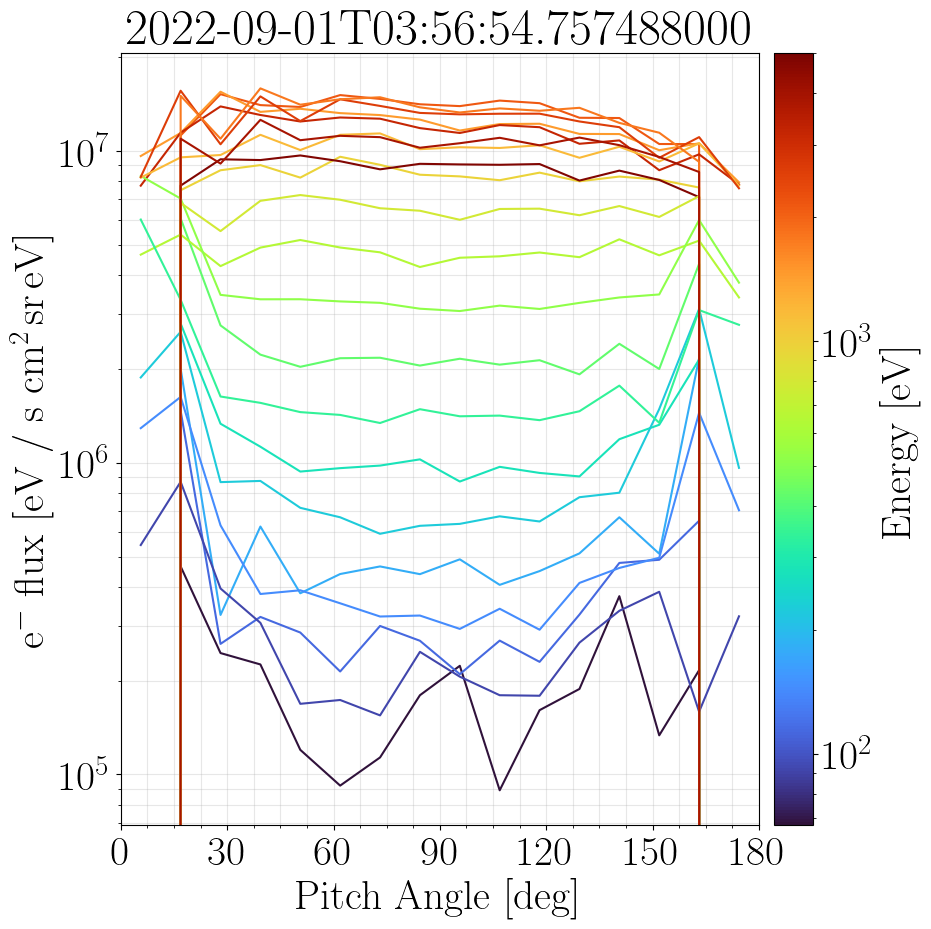

In [9]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
import pyspedas as psp, pytplot as pt, pandas as pd
from matplotlib.ticker import MultipleLocator

# ---- 時刻と trange ----
pt.del_data('*')

mpl.rcdefaults()


mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Computer Modern Roman']
mpl.rcParams['mathtext.fontset'] = 'cm'
font_size = 30
plt.rcParams["font.size"] = font_size

target = np.datetime64('2022-09-01T03:57:00')
dt     = np.timedelta64(30, 's')
str_t  = lambda t: str(t.astype('datetime64[s]')).replace('-', '').replace('T', '/')
trange = [str_t(target-dt), str_t(target+dt)]

# ---- データ ----
psp.erg.lepe(trange, datatype='3dflux', level='l2')                       # 3-D distribution
psp.erg.mgf(trange, datatype='64hz',  level='l2', coord='dsi')            # 磁場 (DSI)
psp.erg.orb(trange, datatype='def',   level='l2')                         # 衛星位置

lep_var = 'erg_lepe_l2_3dflux_FEDU'

flux = pt.data_quants['erg_lepe_l2_3dflux_FEDU']
energy_array = flux.v1[0, :]

# 最も近い時刻インデックス
tid = int(np.abs(pd.to_datetime(flux.time.values, unit='s')
                 - pd.to_datetime(str(target))).argmin())

fig, ax = plt.subplots(figsize=(10, 10))
norm = mpl.colors.LogNorm(vmin=np.nanmin(energy_array), vmax=5E3)
cmap = plt.cm.turbo
ax.set_xlim(0, 180)
ax.set_xlabel('Pitch Angle [deg]')
ax.xaxis.set_major_locator(MultipleLocator(30))
ax.set_yscale('log')
ax.set_ylabel(r'$\mathrm{e}^-$ flux [eV / s cm$^{2}$\,sr\,eV]')
ax.minorticks_on()
ax.grid(which='both', alpha=0.3)
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap=cmap), ax=ax, pad=0.02)
cb.set_label('Energy [eV]')


# pitch angle
for i, E in enumerate(energy_array):
    print(E.values)
    if ~np.isnan(E.values) and E.values < 5E3:
        psp.erg.erg_lep_part_products(lep_var, outputs='pa',
                                        trange=trange,
                                        energy=[np.floor(E.values), np.ceil(E.values)],
                                        mag_name='erg_mgf_l2_mag_64hz_dsi',
                                    pos_name='erg_orb_l2_pos_gse', suffix='_PA')
        flux_pitch = pt.data_quants['erg_lepe_l2_3dflux_FEDU_pa_PA'][tid, :] * E.values
        pitch_angle_array = flux_pitch.spec_bins.values

        print(pitch_angle_array)
        print("")
        print(flux_pitch)

        plt.title(flux.time.values[tid])
        plt.plot(pitch_angle_array, flux_pitch, color=cmap(norm(energy_array[i])))

fig.tight_layout()


In [ ]:
# outputs='pa'
psp.erg.erg_lep_part_products(lep_var, outputs='pa',
                              mag_name='erg_mgf_l2_mag_64hz_dsi',
                              pos_name='erg_orb_l2_pos_gse',
                              trange=trange, suffix='_PA')

# --- 取り出し ---
E_var  = pt.data_quants['erg_lepe_l2_3dflux_FEDU_energy_E']
PA_var = pt.data_quants['erg_lepe_l2_3dflux_FEDU_pa_PA']

# 最も近い時刻インデックス
tid = int(np.abs(pd.to_datetime(E_var.time.values, unit='s')
                 - pd.to_datetime(str(target))).argmin())

energy_eV = E_var.spec_bins[tid]                # shape (32)
pitch_deg = PA_var.spec_bins[tid]               # shape (16)
flux_ep   = PA_var.data[tid]               # shape (16) (#/s/cm²/sr/eV)

print(energy_eV.shape, pitch_deg.shape, flux_ep.shape)

# --- 描画 ---
fig, ax = plt.subplots(figsize=(4.5,4.5))
norm = mpl.colors.LogNorm(vmin=np.nanmin(energy_eV), vmax=np.nanmax(energy_eV))
cmap = plt.cm.turbo

for i, E in enumerate(energy_eV):
    ax.plot(pitch_deg, flux_ep[i, :], color=cmap(norm(E)), lw=1)

ax.set_xlim(0,180); ax.set_xlabel('Pitch angle [deg]')
ax.set_yscale('log'); ax.set_ylabel(r'$e^-$ flux [s$^{-1}$ cm$^{-2}$ sr$^{-1}$ eV$^{-1}$]')
for x,ls in [(78,'-'),(90,'-'),(102,'--')]:
    ax.axvline(x, color='r' if x!=90 else 'k', ls=ls, lw=0.8)

cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap=cmap), ax=ax, pad=0.02)
cb.set_label('Energy [eV]')
ax.set_title(str(target))
plt.tight_layout(); plt.show()

08-Jul-25 00:17:54: Downloading remote index: https://ergsc.isee.nagoya-u.ac.jp/data/ergsc/satellite/erg/pwe/efd/l2/spec/2022/09/
08-Jul-25 00:17:54: File is current: /mnt/j/observation_data//ergsc/satellite/erg/pwe/efd/l2/spec/2022/09/erg_pwe_efd_l2_spec_20220901_v02_03.cdf
08-Jul-25 00:17:54: Downloading remote index: https://ergsc.isee.nagoya-u.ac.jp/data/ergsc/satellite/erg/lepe/l2/3dflux/2022/09/
08-Jul-25 00:17:54: File is current: /mnt/j/observation_data//ergsc/satellite/erg/lepe/l2/3dflux/2022/09/erg_lepe_l2_3dflux_20220901_v04_01.cdf


 
 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Plasma Wave Experiment (PWE) Electric Field Data (EFD) Level 2 spectrum data']

Information about ERG PWE EFD

PI:  ['Yoshiya Kasahara']
Affiliation:  ['Kanazawa University']

RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en
RoR of PWE/EFD: https://ergsc.isee.nagoya-u.ac.jp/mw/index.php/ErgSat/Pwe/Efd

Contact: erg_pwe_info at isee.nagoya-u.ac.jp
**************************************************************************


08-Jul-25 00:18:00: Variable FEDU DEPEND_1 attribute FEDU_Energy has too many dimensions (3). Keeping extra dimensions (for now).
08-Jul-25 00:18:01: Variable Count_Rate DEPEND_1 attribute FEDU_Energy has too many dimensions (3). Keeping extra dimensions (for now).
08-Jul-25 00:18:01: Variable Count_Rate_BG DEPEND_1 attribute FEDU_Energy has too many dimensions (3). Keeping extra dimensions (for now).
08-Jul-25 00:18:03: erg_lepe_l2_3dflux_FEDU contains negative values; setting the z-axis to log scale will cause the negative values to be ignored on figures.
08-Jul-25 00:18:03: Downloading remote index: https://ergsc.isee.nagoya-u.ac.jp/data/ergsc/satellite/erg/mgf/l2/64hz/2022/09/


 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Low-Energy Particle experiments - electron analyzer (LEP-e) Level 2 3D electron flux data']

Information about ERG LEPe

PI:  ['Shiang-Yu Wang']
Affiliation:  ['Academia Sinica, Taiwan']

RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en
RoR of LEPe L2: https://ergsc.isee.nagoya-u.ac.jp/mw/index.php/ErgSat/Lepe

Contact: erg_lepe_info at isee.nagoya-u.ac.jp
**************************************************************************


08-Jul-25 00:18:05: File is current: /mnt/j/observation_data//ergsc/satellite/erg/mgf/l2/64hz/2022/09/erg_mgf_l2_64hz_dsi_2022090103_v04.05.cdf
08-Jul-25 00:18:05: File is current: /mnt/j/observation_data//ergsc/satellite/erg/mgf/l2/64hz/2022/09/erg_mgf_l2_64hz_dsi_2022090104_v04.05.cdf
08-Jul-25 00:18:06: Downloading remote index: https://ergsc.isee.nagoya-u.ac.jp/data/ergsc/satellite/erg/orb/def/2022/


 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Magnetic Field Experiment (MGF) Level 2 64 Hz resolution magnetic field data']

Information about ERG MGF

PI:  ['Ayako Matsuoka']
Affiliation:  ['Data Analysis Center for Geomagnetism and Space Magnetism, Graduate School of Science, Kyoto University, Kitashirakawa-Oiwake Cho, Sakyo-ku Kyoto 606-8502, Japan']

RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en
RoR of MGF L2: https://ergsc.isee.nagoya-u.ac.jp/mw/index.php/ErgSat/Mgf
Contact: erg_mgf_info at isee.nagoya-u.ac.jp
**************************************************************************


08-Jul-25 00:18:06: File is current: /mnt/j/observation_data//ergsc/satellite/erg/orb/def/2022/erg_orb_l2_20220901_v05.cdf
08-Jul-25 00:18:06: Unknown option supplied: vertical_spacing


 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************


08-Jul-25 00:18:09: /home/satanka/Documents/observation_workspace/.venv_pyspedas/lib/python3.12/site-packages/pyspedas/projects/erg/satellite/erg/particle/erg_pgs_make_e_spec.py:30: RuntimeWarning: invalid value encountered in divide
  ave = data_array.sum(axis=1) / data['bins'].sum(axis=1)

08-Jul-25 00:18:11: erg_mgf_l2_mag_64hz_dsi copied to erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:18:11: tinterpol (linear) was applied to: erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:18:11: erg_orb_l2_pos_gse copied to erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:18:11: tinterpol (linear) was applied to: erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:18:11: erg_orb_l2_pos_gse_pgs_temp copied to pos_pgs_temp
08-Jul-25 00:18:11: ['gse', 'gsm', 'sm']
08-Jul-25 00:18:11: Running transformation: subgse2gsm
08-Jul-25 00:18:11: Running transformation: subgsm2sm
08-Jul-25 00:18:11: Setting coordinate system for pos_pgs_temp
08-Jul-25 00:18:11: Output variable: pos_pgs_temp
08-Jul-25 00:18:11: ['sm', 'gsm', 'gse

 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************
J2000 --> DSI


08-Jul-25 00:18:16: erg_mgf_l2_mag_64hz_dsi copied to erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:18:16: tinterpol (linear) was applied to: erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:18:16: erg_orb_l2_pos_gse copied to erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:18:16: tinterpol (linear) was applied to: erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:18:16: erg_orb_l2_pos_gse_pgs_temp copied to pos_pgs_temp
08-Jul-25 00:18:16: ['gse', 'gsm', 'sm']
08-Jul-25 00:18:16: Running transformation: subgse2gsm
08-Jul-25 00:18:16: Running transformation: subgsm2sm
08-Jul-25 00:18:16: Setting coordinate system for pos_pgs_temp
08-Jul-25 00:18:16: Output variable: pos_pgs_temp
08-Jul-25 00:18:16: ['sm', 'gsm', 'gse', 'gei', 'j2000']
08-Jul-25 00:18:16: Running transformation: subsm2gsm
08-Jul-25 00:18:16: Running transformation: subgsm2gse
08-Jul-25 00:18:16: Running transformation: subgse2gei
08-Jul-25 00:18:16: Running transformation: subgei2j2000
08-Jul-25 00:18:16: Setting coordinate system for phi

 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************
J2000 --> DSI


08-Jul-25 00:18:20: erg_mgf_l2_mag_64hz_dsi copied to erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:18:20: tinterpol (linear) was applied to: erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:18:20: erg_orb_l2_pos_gse copied to erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:18:20: tinterpol (linear) was applied to: erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:18:20: erg_orb_l2_pos_gse_pgs_temp copied to pos_pgs_temp
08-Jul-25 00:18:20: ['gse', 'gsm', 'sm']
08-Jul-25 00:18:20: Running transformation: subgse2gsm
08-Jul-25 00:18:20: Running transformation: subgsm2sm
08-Jul-25 00:18:20: Setting coordinate system for pos_pgs_temp
08-Jul-25 00:18:20: Output variable: pos_pgs_temp
08-Jul-25 00:18:20: ['sm', 'gsm', 'gse', 'gei', 'j2000']
08-Jul-25 00:18:20: Running transformation: subsm2gsm
08-Jul-25 00:18:20: Running transformation: subgsm2gse
08-Jul-25 00:18:20: Running transformation: subgse2gei
08-Jul-25 00:18:20: Running transformation: subgei2j2000
08-Jul-25 00:18:20: Setting coordinate system for phi

 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************
J2000 --> DSI


08-Jul-25 00:18:23: erg_mgf_l2_mag_64hz_dsi copied to erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:18:23: tinterpol (linear) was applied to: erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:18:23: erg_orb_l2_pos_gse copied to erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:18:23: tinterpol (linear) was applied to: erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:18:23: erg_orb_l2_pos_gse_pgs_temp copied to pos_pgs_temp
08-Jul-25 00:18:23: ['gse', 'gsm', 'sm']
08-Jul-25 00:18:23: Running transformation: subgse2gsm
08-Jul-25 00:18:23: Running transformation: subgsm2sm
08-Jul-25 00:18:23: Setting coordinate system for pos_pgs_temp
08-Jul-25 00:18:23: Output variable: pos_pgs_temp
08-Jul-25 00:18:23: ['sm', 'gsm', 'gse', 'gei', 'j2000']
08-Jul-25 00:18:23: Running transformation: subsm2gsm
08-Jul-25 00:18:23: Running transformation: subgsm2gse
08-Jul-25 00:18:23: Running transformation: subgse2gei
08-Jul-25 00:18:23: Running transformation: subgei2j2000
08-Jul-25 00:18:23: Setting coordinate system for phi

 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************
J2000 --> DSI


08-Jul-25 00:18:27: erg_mgf_l2_mag_64hz_dsi copied to erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:18:27: tinterpol (linear) was applied to: erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:18:27: erg_orb_l2_pos_gse copied to erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:18:27: tinterpol (linear) was applied to: erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:18:27: erg_orb_l2_pos_gse_pgs_temp copied to pos_pgs_temp
08-Jul-25 00:18:27: ['gse', 'gsm', 'sm']
08-Jul-25 00:18:27: Running transformation: subgse2gsm
08-Jul-25 00:18:27: Running transformation: subgsm2sm
08-Jul-25 00:18:27: Setting coordinate system for pos_pgs_temp
08-Jul-25 00:18:27: Output variable: pos_pgs_temp
08-Jul-25 00:18:27: ['sm', 'gsm', 'gse', 'gei', 'j2000']
08-Jul-25 00:18:27: Running transformation: subsm2gsm
08-Jul-25 00:18:27: Running transformation: subgsm2gse
08-Jul-25 00:18:27: Running transformation: subgse2gei
08-Jul-25 00:18:27: Running transformation: subgei2j2000
08-Jul-25 00:18:27: Setting coordinate system for phi

 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************
J2000 --> DSI


08-Jul-25 00:18:30: erg_mgf_l2_mag_64hz_dsi copied to erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:18:30: tinterpol (linear) was applied to: erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:18:30: erg_orb_l2_pos_gse copied to erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:18:30: tinterpol (linear) was applied to: erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:18:30: erg_orb_l2_pos_gse_pgs_temp copied to pos_pgs_temp
08-Jul-25 00:18:30: ['gse', 'gsm', 'sm']
08-Jul-25 00:18:30: Running transformation: subgse2gsm
08-Jul-25 00:18:30: Running transformation: subgsm2sm
08-Jul-25 00:18:30: Setting coordinate system for pos_pgs_temp
08-Jul-25 00:18:30: Output variable: pos_pgs_temp
08-Jul-25 00:18:30: ['sm', 'gsm', 'gse', 'gei', 'j2000']
08-Jul-25 00:18:30: Running transformation: subsm2gsm
08-Jul-25 00:18:30: Running transformation: subgsm2gse
08-Jul-25 00:18:30: Running transformation: subgse2gei
08-Jul-25 00:18:30: Running transformation: subgei2j2000
08-Jul-25 00:18:30: Setting coordinate system for phi

 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************
J2000 --> DSI


08-Jul-25 00:18:34: erg_mgf_l2_mag_64hz_dsi copied to erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:18:34: tinterpol (linear) was applied to: erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:18:34: erg_orb_l2_pos_gse copied to erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:18:34: tinterpol (linear) was applied to: erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:18:34: erg_orb_l2_pos_gse_pgs_temp copied to pos_pgs_temp
08-Jul-25 00:18:34: ['gse', 'gsm', 'sm']
08-Jul-25 00:18:34: Running transformation: subgse2gsm
08-Jul-25 00:18:34: Running transformation: subgsm2sm
08-Jul-25 00:18:34: Setting coordinate system for pos_pgs_temp
08-Jul-25 00:18:34: Output variable: pos_pgs_temp
08-Jul-25 00:18:34: ['sm', 'gsm', 'gse', 'gei', 'j2000']
08-Jul-25 00:18:34: Running transformation: subsm2gsm
08-Jul-25 00:18:34: Running transformation: subgsm2gse
08-Jul-25 00:18:34: Running transformation: subgse2gei
08-Jul-25 00:18:34: Running transformation: subgei2j2000
08-Jul-25 00:18:34: Setting coordinate system for phi

 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************
J2000 --> DSI


08-Jul-25 00:18:37: erg_mgf_l2_mag_64hz_dsi copied to erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:18:38: tinterpol (linear) was applied to: erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:18:38: erg_orb_l2_pos_gse copied to erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:18:38: tinterpol (linear) was applied to: erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:18:38: erg_orb_l2_pos_gse_pgs_temp copied to pos_pgs_temp
08-Jul-25 00:18:38: ['gse', 'gsm', 'sm']
08-Jul-25 00:18:38: Running transformation: subgse2gsm
08-Jul-25 00:18:38: Running transformation: subgsm2sm
08-Jul-25 00:18:38: Setting coordinate system for pos_pgs_temp
08-Jul-25 00:18:38: Output variable: pos_pgs_temp
08-Jul-25 00:18:38: ['sm', 'gsm', 'gse', 'gei', 'j2000']
08-Jul-25 00:18:38: Running transformation: subsm2gsm
08-Jul-25 00:18:38: Running transformation: subgsm2gse
08-Jul-25 00:18:38: Running transformation: subgse2gei
08-Jul-25 00:18:38: Running transformation: subgei2j2000
08-Jul-25 00:18:38: Setting coordinate system for phi

 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************
J2000 --> DSI


08-Jul-25 00:18:41: erg_mgf_l2_mag_64hz_dsi copied to erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:18:41: tinterpol (linear) was applied to: erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:18:41: erg_orb_l2_pos_gse copied to erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:18:41: tinterpol (linear) was applied to: erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:18:41: erg_orb_l2_pos_gse_pgs_temp copied to pos_pgs_temp
08-Jul-25 00:18:41: ['gse', 'gsm', 'sm']
08-Jul-25 00:18:41: Running transformation: subgse2gsm
08-Jul-25 00:18:41: Running transformation: subgsm2sm
08-Jul-25 00:18:41: Setting coordinate system for pos_pgs_temp
08-Jul-25 00:18:41: Output variable: pos_pgs_temp
08-Jul-25 00:18:41: ['sm', 'gsm', 'gse', 'gei', 'j2000']
08-Jul-25 00:18:41: Running transformation: subsm2gsm
08-Jul-25 00:18:41: Running transformation: subgsm2gse
08-Jul-25 00:18:41: Running transformation: subgse2gei
08-Jul-25 00:18:41: Running transformation: subgei2j2000
08-Jul-25 00:18:41: Setting coordinate system for phi

 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************
J2000 --> DSI


08-Jul-25 00:18:44: erg_mgf_l2_mag_64hz_dsi copied to erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:18:44: tinterpol (linear) was applied to: erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:18:44: erg_orb_l2_pos_gse copied to erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:18:45: tinterpol (linear) was applied to: erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:18:45: erg_orb_l2_pos_gse_pgs_temp copied to pos_pgs_temp
08-Jul-25 00:18:45: ['gse', 'gsm', 'sm']
08-Jul-25 00:18:45: Running transformation: subgse2gsm
08-Jul-25 00:18:45: Running transformation: subgsm2sm
08-Jul-25 00:18:45: Setting coordinate system for pos_pgs_temp
08-Jul-25 00:18:45: Output variable: pos_pgs_temp
08-Jul-25 00:18:45: ['sm', 'gsm', 'gse', 'gei', 'j2000']
08-Jul-25 00:18:45: Running transformation: subsm2gsm
08-Jul-25 00:18:45: Running transformation: subgsm2gse
08-Jul-25 00:18:45: Running transformation: subgse2gei
08-Jul-25 00:18:45: Running transformation: subgei2j2000
08-Jul-25 00:18:45: Setting coordinate system for phi

 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************
J2000 --> DSI


08-Jul-25 00:18:48: erg_mgf_l2_mag_64hz_dsi copied to erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:18:48: tinterpol (linear) was applied to: erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:18:48: erg_orb_l2_pos_gse copied to erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:18:48: tinterpol (linear) was applied to: erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:18:48: erg_orb_l2_pos_gse_pgs_temp copied to pos_pgs_temp
08-Jul-25 00:18:48: ['gse', 'gsm', 'sm']
08-Jul-25 00:18:48: Running transformation: subgse2gsm
08-Jul-25 00:18:48: Running transformation: subgsm2sm
08-Jul-25 00:18:48: Setting coordinate system for pos_pgs_temp
08-Jul-25 00:18:48: Output variable: pos_pgs_temp
08-Jul-25 00:18:48: ['sm', 'gsm', 'gse', 'gei', 'j2000']
08-Jul-25 00:18:48: Running transformation: subsm2gsm
08-Jul-25 00:18:48: Running transformation: subgsm2gse
08-Jul-25 00:18:48: Running transformation: subgse2gei
08-Jul-25 00:18:48: Running transformation: subgei2j2000
08-Jul-25 00:18:48: Setting coordinate system for phi

 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************
J2000 --> DSI


08-Jul-25 00:18:52: erg_mgf_l2_mag_64hz_dsi copied to erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:18:52: tinterpol (linear) was applied to: erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:18:52: erg_orb_l2_pos_gse copied to erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:18:52: tinterpol (linear) was applied to: erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:18:52: erg_orb_l2_pos_gse_pgs_temp copied to pos_pgs_temp
08-Jul-25 00:18:52: ['gse', 'gsm', 'sm']
08-Jul-25 00:18:52: Running transformation: subgse2gsm
08-Jul-25 00:18:52: Running transformation: subgsm2sm
08-Jul-25 00:18:52: Setting coordinate system for pos_pgs_temp
08-Jul-25 00:18:52: Output variable: pos_pgs_temp
08-Jul-25 00:18:52: ['sm', 'gsm', 'gse', 'gei', 'j2000']
08-Jul-25 00:18:52: Running transformation: subsm2gsm
08-Jul-25 00:18:52: Running transformation: subgsm2gse
08-Jul-25 00:18:52: Running transformation: subgse2gei
08-Jul-25 00:18:52: Running transformation: subgei2j2000
08-Jul-25 00:18:52: Setting coordinate system for phi

 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************
J2000 --> DSI


08-Jul-25 00:18:55: erg_mgf_l2_mag_64hz_dsi copied to erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:18:55: tinterpol (linear) was applied to: erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:18:55: erg_orb_l2_pos_gse copied to erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:18:55: tinterpol (linear) was applied to: erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:18:55: erg_orb_l2_pos_gse_pgs_temp copied to pos_pgs_temp
08-Jul-25 00:18:55: ['gse', 'gsm', 'sm']
08-Jul-25 00:18:55: Running transformation: subgse2gsm
08-Jul-25 00:18:55: Running transformation: subgsm2sm
08-Jul-25 00:18:55: Setting coordinate system for pos_pgs_temp
08-Jul-25 00:18:55: Output variable: pos_pgs_temp
08-Jul-25 00:18:55: ['sm', 'gsm', 'gse', 'gei', 'j2000']
08-Jul-25 00:18:55: Running transformation: subsm2gsm
08-Jul-25 00:18:55: Running transformation: subgsm2gse
08-Jul-25 00:18:55: Running transformation: subgse2gei
08-Jul-25 00:18:55: Running transformation: subgei2j2000
08-Jul-25 00:18:55: Setting coordinate system for phi

 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************
J2000 --> DSI


08-Jul-25 00:18:59: erg_mgf_l2_mag_64hz_dsi copied to erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:18:59: tinterpol (linear) was applied to: erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:18:59: erg_orb_l2_pos_gse copied to erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:18:59: tinterpol (linear) was applied to: erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:18:59: erg_orb_l2_pos_gse_pgs_temp copied to pos_pgs_temp
08-Jul-25 00:18:59: ['gse', 'gsm', 'sm']
08-Jul-25 00:18:59: Running transformation: subgse2gsm
08-Jul-25 00:18:59: Running transformation: subgsm2sm
08-Jul-25 00:18:59: Setting coordinate system for pos_pgs_temp
08-Jul-25 00:18:59: Output variable: pos_pgs_temp
08-Jul-25 00:18:59: ['sm', 'gsm', 'gse', 'gei', 'j2000']
08-Jul-25 00:18:59: Running transformation: subsm2gsm
08-Jul-25 00:18:59: Running transformation: subgsm2gse
08-Jul-25 00:18:59: Running transformation: subgse2gei
08-Jul-25 00:18:59: Running transformation: subgei2j2000
08-Jul-25 00:18:59: Setting coordinate system for phi

 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************
J2000 --> DSI


08-Jul-25 00:19:00: /home/satanka/Documents/observation_workspace/.venv_pyspedas/lib/python3.12/site-packages/pytplot/MPLPlotter/tplot.py:616: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  this_axis.set_ylim(yrange)

08-Jul-25 00:19:00: Variable erg_lepe_pa_800-900eV contains all-zero data


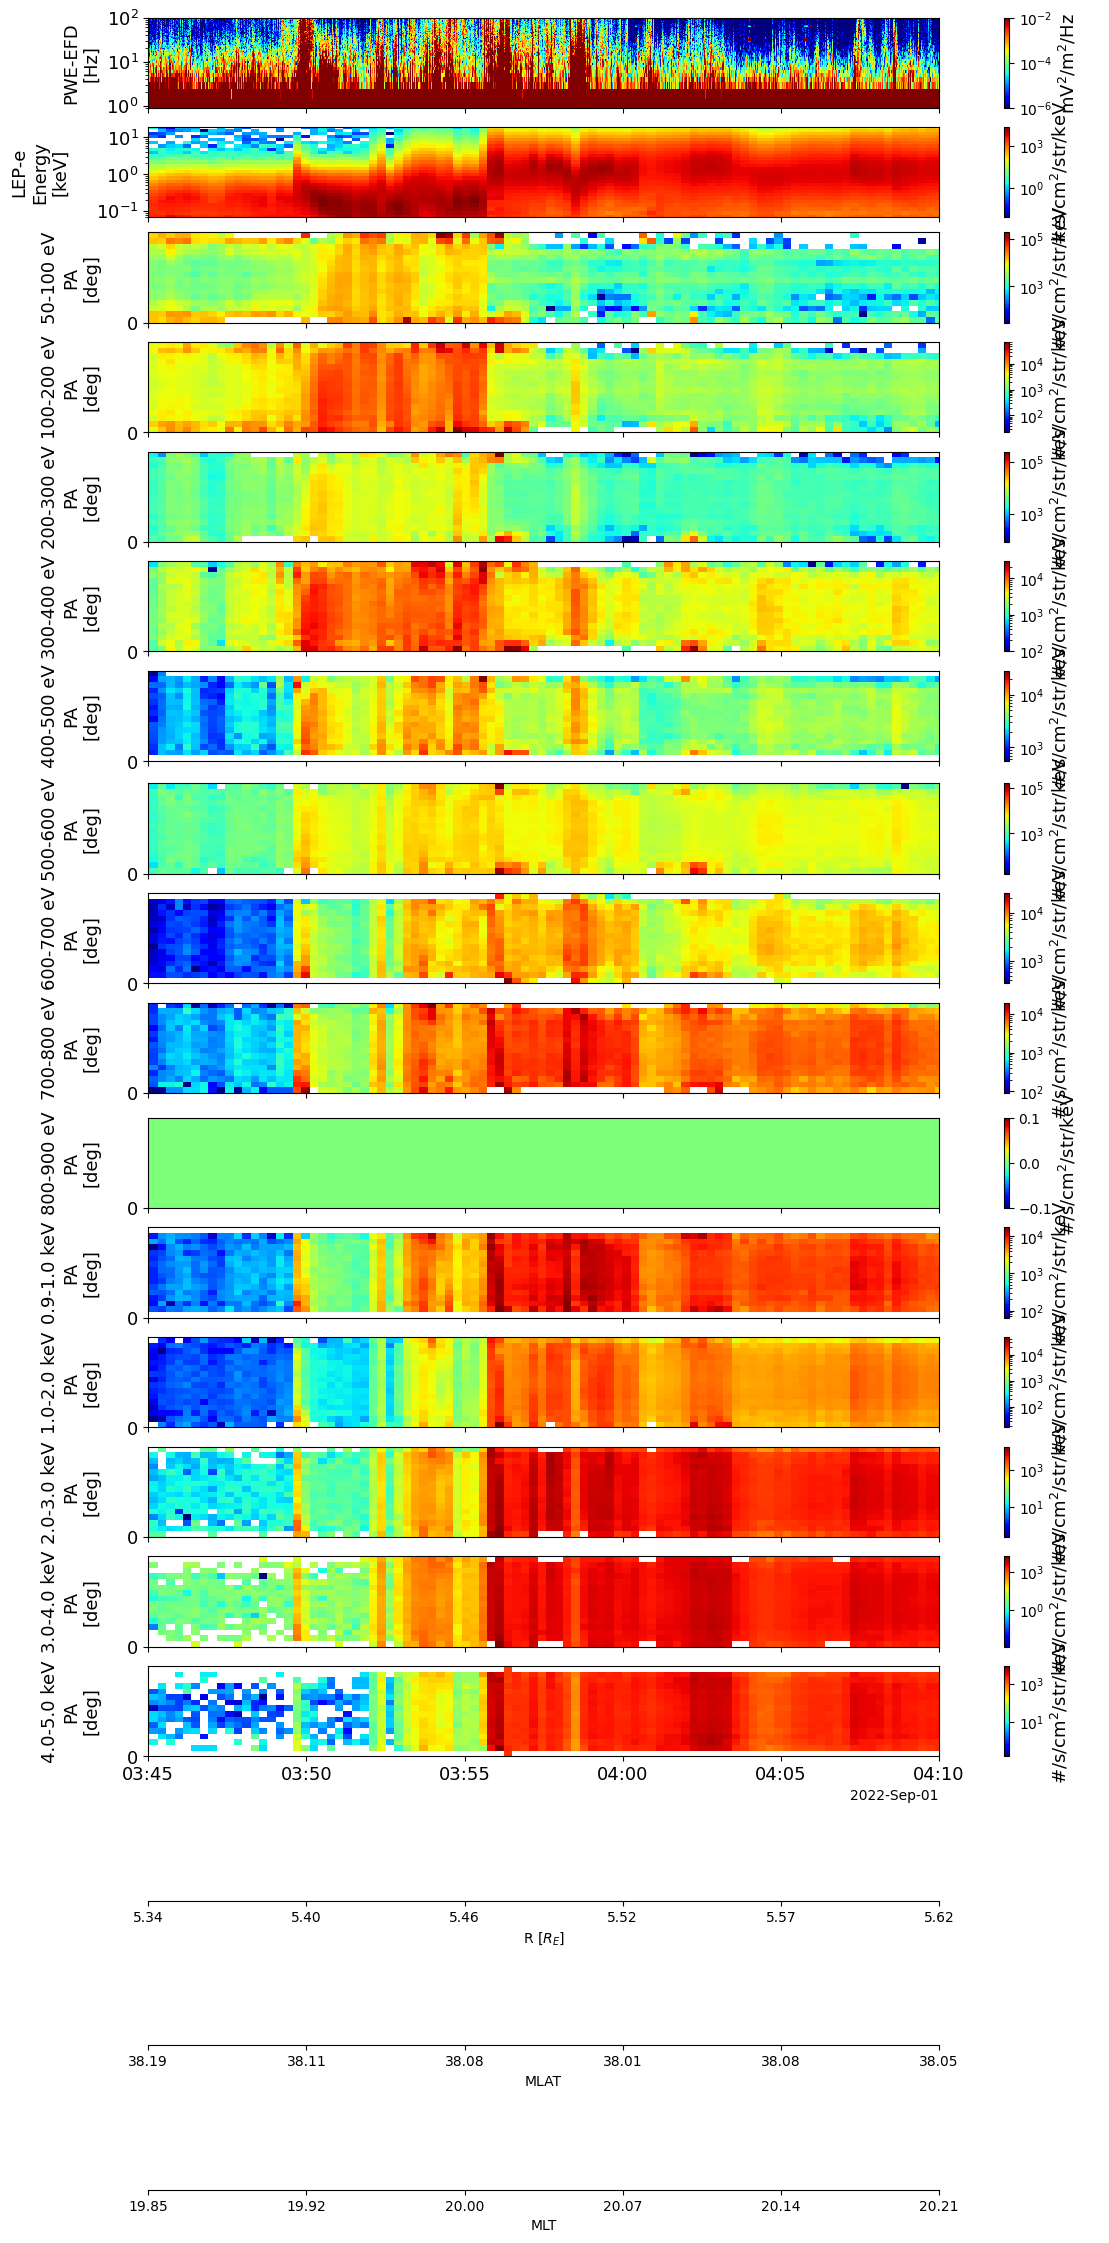

In [48]:
import pytplot as pt
import pyspedas as psp
import numpy as np

# ------------------------------------------------------------
# 基本設定 & データロード（ここはほぼそのまま）
# ------------------------------------------------------------
pt.del_data('*')
pt.timespan('2022-09-01/03:45:00',25,keyword='minute')
mpl.rcdefaults()

# データのダウンロード
trange = ['20220901/03:40:00', '20220901/04:15:00']
psp.erg.pwe_efd(trange, level='l2', datatype='spec')
psp.erg.lepe(trange, level='l2', datatype='3dflux')
psp.erg.mgf(trange, level='l2', datatype='64hz', coord='dsi')
psp.erg.orb(trange, level='l2', datatype='def')

# ------------------------------------------------------------
# 可変エネルギービン定義（eV 単位で揃える）
#  50-100 eV, 100-200 eV, …, 900-1000 eV, 1-2 keV, … 4-5 keV
# ------------------------------------------------------------
step100 = [(lo, lo+100) for lo in range(100, 1000, 100)]
bins_ev = [(50, 100)] + step100 + [(k*1000, (k+1)*1000) for k in range(1, 5)]

# ↓ tplot 変数名を自動生成
def make_name(lo, hi):
    unit = 'keV' if hi >= 1000 else 'eV'
    lo_u = lo//1000 if unit=='keV' else lo
    hi_u = hi//1000 if unit=='keV' else hi
    return f'erg_lepe_pa_{lo_u}-{hi_u}{unit}'

# ------------------------------------------------------------
# Figure サイズ & フォント一括設定
# ------------------------------------------------------------
panel_num  = len(bins_ev) + 2          # +2 = PWE-EFD, Energy スペクトル
orbit_num  = 3                         # R, MLAT, MLT
inch_per   = 1.4                       # １パネル高さ
pt.tplot_options('xsize', 11)
pt.tplot_options('ysize', inch_per*(panel_num))
pt.tplot_options('vertical_spacing', 70)

# ------------------------------------------------------------
# PWE‐EFD と全エネルギー・スペクトルは先に用意
# ------------------------------------------------------------
psp.erg.erg_lep_part_products(
    'erg_lepe_l2_3dflux_FEDU', outputs='energy',
    mag_name='erg_mgf_l2_mag_64hz_dsi',
    pos_name='erg_orb_l2_pos_gse', trange=trange)

energy_flux = pt.data_quants['erg_lepe_l2_3dflux_FEDU_energy']
pt.store_data('erg_lepe_energy_keV', data={
    'x': energy_flux.time,
    'y': energy_flux.data,
    'v': energy_flux.spec_bins*1e-3}, attr_dict=energy_flux.attrs)
pt.options('erg_lepe_energy_keV', 'ytitle', 'LEP-e\nEnergy\n[keV]')
pt.options('erg_lepe_energy_keV', 'ylog', 1)
pt.options('erg_lepe_energy_keV', 'ztitle', '#/s/cm^2/str/keV')
#pt.options('erg_lepe_energy_keV', 'zrange', [4e2, 1e8])

# ------------------------------------------------------------
# 各ピッチ角スペクトルをループで生成
# ------------------------------------------------------------
pa_vars = []            # プロット用変数名を貯める
for lo, hi in bins_ev:
    vname = make_name(lo, hi)
    # ① スペクトル生成
    psp.erg.erg_lep_part_products(
        'erg_lepe_l2_3dflux_FEDU', outputs='pa',
        energy=[lo, hi],
        mag_name='erg_mgf_l2_mag_64hz_dsi',
        pos_name='erg_orb_l2_pos_gse',
        trange=trange, suffix=f'_{lo}-{hi}')
    # ② tplot 変数へコピー（単位を eV→keV 揃え, 10^3 でスケール）
    src = pt.data_quants[f'erg_lepe_l2_3dflux_FEDU_pa_{lo}-{hi}']
    pt.store_data(vname, data={'x': src.time, 'y': src.data,
                               'v': src.spec_bins*1e-3}, attr_dict=src.attrs)
    # ③ 表示オプション
    lab_unit = 'keV' if hi >= 1000 else 'eV'
    pt.options(vname, 'ytitle',
               f'{lo/1000 if lab_unit=="keV" else lo}'
               f'-{hi/1000 if lab_unit=="keV" else hi} {lab_unit}\nPA\n[deg]')
    #pt.options(vname, 'zrange', [1e5, 1e8])
    pt.options(vname, 'y_major_ticks', [0, 45, 90, 135, 180])
    pt.options(vname, 'y_minor_tick_interval', 15)
    pt.options(vname, 'ztitle', '#/s/cm^2/str/keV')
    pa_vars.append(vname)


# ------------------------------------------------------------
# 軌道座標ラベル調整
# ------------------------------------------------------------
orb_labels = pt.split_vec('erg_orb_l2_pos_rmlatmlt')
for lbl, ttl in zip(orb_labels, [r'R [$R_E$]', 'MLAT', 'MLT']):
    pt.options(lbl, 'ytitle', ttl)
    pt.options(lbl, 'panel_size', 0.05)

# ------------------------------------------------------------
# PWE‐EFD の軸ラベル
# ------------------------------------------------------------
pt.options('erg_pwe_efd_l2_spec_spectra', 'ytitle', 'PWE-EFD')
pt.options('erg_pwe_efd_l2_spec_spectra', 'ztitle', 'mV$^2$/m$^2$/Hz')

# ------------------------------------------------------------
# 最終描画
# ------------------------------------------------------------

pt.tplot_options('axis_font_size', 13)
pt.tplot_options('title_size', 13)
pt.tplot_options('charsize', 13)

all_panels = ['erg_pwe_efd_l2_spec_spectra',
              'erg_lepe_energy_keV'] + pa_vars
pt.tplot(all_panels, var_label=orb_labels)


# LEP-i

pt.data_quants['erg_lepi_l2_3dflux_FPDU_Energy']<br>
{'data': array([ 2.54737e+01,  2.54737e+01,  1.91745e+01,  1.44251e+01,<br>
        1.08508e+01,  8.16190e+00,  6.13930e+00,  4.61790e+00,<br>
        3.47360e+00,  2.61280e+00,  1.96530e+00,  1.47830e+00,<br>
        1.11190e+00,  8.36400e-01,  6.29100e-01,  4.73200e-01,<br>
        3.56000e-01,  2.67800e-01,  2.01400e-01,  1.51500e-01,<br>
        1.14000e-01,  8.57000e-02,  6.45000e-02,  4.85000e-02,<br>
        3.58000e-02,  2.94000e-02,  2.30000e-02,  1.66000e-02,<br>
        1.03000e-02,  3.90000e-03, -2.50000e-03, -4.71000e-02],<br>
      dtype=float32), 'name': 'erg_lepi_l2_3dflux_FPDU_Energy'}<br>
→ 32個のbin ('0'と'1'の値が一致、'30'と'31'の値が負になっている)

3.9 eV, 10.3 eV, 16.6 eV, 23 eV, 29.4 eV, 35.8 eV, 48.5 eV, 64.5 eV, 85.7 eV, 114 eV, 151.5 eV, 201.4 eV, 267.8 eV, 356 eV, 473.2 eV, 629.1 eV, 836.4 eV, 1.1119 keV, 1.4783 keV, 1.9653 keV, 2.6128 keV, 3.4736 keV, 4.6179 keV, ...

08-Jul-25 00:41:04: del_data: No valid tplot variables found, returning
08-Jul-25 00:41:04: Downloading remote index: https://ergsc.isee.nagoya-u.ac.jp/data/ergsc/satellite/erg/pwe/efd/l2/spec/2022/09/
08-Jul-25 00:41:04: File is current: /mnt/j/observation_data//ergsc/satellite/erg/pwe/efd/l2/spec/2022/09/erg_pwe_efd_l2_spec_20220901_v02_03.cdf
08-Jul-25 00:41:05: Downloading remote index: https://ergsc.isee.nagoya-u.ac.jp/data/ergsc/satellite/erg/lepi/l2/3dflux/2022/09/
08-Jul-25 00:41:05: File is current: /mnt/j/observation_data//ergsc/satellite/erg/lepi/l2/3dflux/2022/09/erg_lepi_l2_3dflux_20220901_v03_00.cdf


 
 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Plasma Wave Experiment (PWE) Electric Field Data (EFD) Level 2 spectrum data']

Information about ERG PWE EFD

PI:  ['Yoshiya Kasahara']
Affiliation:  ['Kanazawa University']

RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en
RoR of PWE/EFD: https://ergsc.isee.nagoya-u.ac.jp/mw/index.php/ErgSat/Pwe/Efd

Contact: erg_pwe_info at isee.nagoya-u.ac.jp
**************************************************************************


08-Jul-25 00:41:13: Variable FPDU_Quality DEPEND_2 attribute FIDU_Channel has length 8, but corresponding data dimension has length 15. Removing attribute.
08-Jul-25 00:41:14: Variable FHEDU_Quality DEPEND_2 attribute FIDU_Channel has length 8, but corresponding data dimension has length 15. Removing attribute.
08-Jul-25 00:41:15: Variable FODU_Quality DEPEND_2 attribute FIDU_Channel has length 8, but corresponding data dimension has length 15. Removing attribute.
08-Jul-25 00:41:15: store_data: Data array for variable erg_lepi_l2_3dflux_FPDU_Quality has 4 dimensions, but only 1 v_n keys plus time. Adding empty v_n keys.
08-Jul-25 00:41:16: store_data: Data array for variable erg_lepi_l2_3dflux_FHEDU_Quality has 4 dimensions, but only 1 v_n keys plus time. Adding empty v_n keys.
08-Jul-25 00:41:17: store_data: Data array for variable erg_lepi_l2_3dflux_FODU_Quality has 4 dimensions, but only 1 v_n keys plus time. Adding empty v_n keys.
08-Jul-25 00:41:17: erg_lepi_l2_3dflux_FPDU copied

 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Low Energy Particle Ion (LEPi) Experiment 3D ion flux data']

Information about ERG LEPi

PI:  ['Kazushi Asamura']
Affiliation:  ['ISAS, Jaxa']

RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en
RoR of LEPi L2: https://ergsc.isee.nagoya-u.ac.jp/mw/index.php/ErgSat/Lepi
RoR of ERG/LEPi: https://ergsc.isee.nagoya-u.ac.jp/mw/index.php/ErgSat/Lepi#Rules_of_the_Road

Contact: erg_lepi_info at isee.nagoya-u.ac.jp
**************************************************************************


08-Jul-25 00:41:17: erg_lepi_l2_3dflux_FPEDU copied to erg_lepi_l2_3dflux_FPEDU_raw
08-Jul-25 00:41:17: erg_lepi_l2_3dflux_FPEDU_sub copied to erg_lepi_l2_3dflux_FPEDU_sub_raw
08-Jul-25 00:41:17: erg_lepi_l2_3dflux_FHEEDU copied to erg_lepi_l2_3dflux_FHEEDU_raw
08-Jul-25 00:41:17: erg_lepi_l2_3dflux_FHEEDU_sub copied to erg_lepi_l2_3dflux_FHEEDU_sub_raw
08-Jul-25 00:41:17: erg_lepi_l2_3dflux_FOEDU copied to erg_lepi_l2_3dflux_FOEDU_raw
08-Jul-25 00:41:17: erg_lepi_l2_3dflux_FOEDU_sub copied to erg_lepi_l2_3dflux_FOEDU_sub_raw
08-Jul-25 00:41:17: erg_lepi_l2_3dflux_FPDU_COUNT_RAW copied to erg_lepi_l2_3dflux_FPDU_COUNT_RAW_raw
08-Jul-25 00:41:18: erg_lepi_l2_3dflux_FPDU_COUNT_RAW_sub copied to erg_lepi_l2_3dflux_FPDU_COUNT_RAW_sub_raw
08-Jul-25 00:41:18: erg_lepi_l2_3dflux_FHEDU_COUNT_RAW copied to erg_lepi_l2_3dflux_FHEDU_COUNT_RAW_raw
08-Jul-25 00:41:18: erg_lepi_l2_3dflux_FHEDU_COUNT_RAW_sub copied to erg_lepi_l2_3dflux_FHEDU_COUNT_RAW_sub_raw
08-Jul-25 00:41:18: erg_lepi_l2_3dflux_F

 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Magnetic Field Experiment (MGF) Level 2 64 Hz resolution magnetic field data']

Information about ERG MGF

PI:  ['Ayako Matsuoka']
Affiliation:  ['Data Analysis Center for Geomagnetism and Space Magnetism, Graduate School of Science, Kyoto University, Kitashirakawa-Oiwake Cho, Sakyo-ku Kyoto 606-8502, Japan']

RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en
RoR of MGF L2: https://ergsc.isee.nagoya-u.ac.jp/mw/index.php/ErgSat/Mgf
Contact: erg_mgf_info at isee.nagoya-u.ac.jp
**************************************************************************


08-Jul-25 00:41:21: File is current: /mnt/j/observation_data//ergsc/satellite/erg/orb/def/2022/erg_orb_l2_20220901_v05.cdf
08-Jul-25 00:41:21: Unknown option supplied: vertical_spacing
08-Jul-25 00:41:21: /home/satanka/Documents/observation_workspace/.venv_pyspedas/lib/python3.12/site-packages/pyspedas/projects/erg/satellite/erg/particle/erg_pgs_make_e_spec.py:30: RuntimeWarning: invalid value encountered in divide
  ave = data_array.sum(axis=1) / data['bins'].sum(axis=1)



 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************


08-Jul-25 00:41:21: erg_mgf_l2_mag_64hz_dsi copied to erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:41:21: tinterpol (linear) was applied to: erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:41:21: erg_orb_l2_pos_gse copied to erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:41:21: tinterpol (linear) was applied to: erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:41:21: erg_orb_l2_pos_gse_pgs_temp copied to pos_pgs_temp
08-Jul-25 00:41:21: ['gse', 'gsm', 'sm']
08-Jul-25 00:41:21: Running transformation: subgse2gsm
08-Jul-25 00:41:21: Running transformation: subgsm2sm
08-Jul-25 00:41:21: Setting coordinate system for pos_pgs_temp
08-Jul-25 00:41:21: Output variable: pos_pgs_temp
08-Jul-25 00:41:21: ['sm', 'gsm', 'gse', 'gei', 'j2000']
08-Jul-25 00:41:21: Running transformation: subsm2gsm
08-Jul-25 00:41:21: Running transformation: subgsm2gse
08-Jul-25 00:41:21: Running transformation: subgse2gei
08-Jul-25 00:41:21: Running transformation: subgei2j2000
08-Jul-25 00:41:21: Setting coordinate system for phi

 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************
J2000 --> DSI


08-Jul-25 00:41:23: erg_mgf_l2_mag_64hz_dsi copied to erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:41:23: tinterpol (linear) was applied to: erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:41:23: erg_orb_l2_pos_gse copied to erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:41:23: tinterpol (linear) was applied to: erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:41:23: erg_orb_l2_pos_gse_pgs_temp copied to pos_pgs_temp
08-Jul-25 00:41:23: ['gse', 'gsm', 'sm']
08-Jul-25 00:41:23: Running transformation: subgse2gsm
08-Jul-25 00:41:23: Running transformation: subgsm2sm
08-Jul-25 00:41:23: Setting coordinate system for pos_pgs_temp
08-Jul-25 00:41:23: Output variable: pos_pgs_temp
08-Jul-25 00:41:23: ['sm', 'gsm', 'gse', 'gei', 'j2000']
08-Jul-25 00:41:23: Running transformation: subsm2gsm
08-Jul-25 00:41:23: Running transformation: subgsm2gse
08-Jul-25 00:41:23: Running transformation: subgse2gei
08-Jul-25 00:41:23: Running transformation: subgei2j2000
08-Jul-25 00:41:23: Setting coordinate system for phi

 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************
J2000 --> DSI


08-Jul-25 00:41:24: erg_mgf_l2_mag_64hz_dsi copied to erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:41:24: tinterpol (linear) was applied to: erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:41:24: erg_orb_l2_pos_gse copied to erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:41:24: tinterpol (linear) was applied to: erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:41:24: erg_orb_l2_pos_gse_pgs_temp copied to pos_pgs_temp
08-Jul-25 00:41:24: ['gse', 'gsm', 'sm']
08-Jul-25 00:41:24: Running transformation: subgse2gsm
08-Jul-25 00:41:24: Running transformation: subgsm2sm
08-Jul-25 00:41:24: Setting coordinate system for pos_pgs_temp
08-Jul-25 00:41:24: Output variable: pos_pgs_temp
08-Jul-25 00:41:24: ['sm', 'gsm', 'gse', 'gei', 'j2000']
08-Jul-25 00:41:24: Running transformation: subsm2gsm
08-Jul-25 00:41:24: Running transformation: subgsm2gse
08-Jul-25 00:41:24: Running transformation: subgse2gei
08-Jul-25 00:41:24: Running transformation: subgei2j2000
08-Jul-25 00:41:24: Setting coordinate system for phi

 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************
J2000 --> DSI


08-Jul-25 00:41:25: erg_mgf_l2_mag_64hz_dsi copied to erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:41:25: tinterpol (linear) was applied to: erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:41:25: erg_orb_l2_pos_gse copied to erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:41:25: tinterpol (linear) was applied to: erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:41:25: erg_orb_l2_pos_gse_pgs_temp copied to pos_pgs_temp
08-Jul-25 00:41:25: ['gse', 'gsm', 'sm']
08-Jul-25 00:41:25: Running transformation: subgse2gsm
08-Jul-25 00:41:25: Running transformation: subgsm2sm
08-Jul-25 00:41:25: Setting coordinate system for pos_pgs_temp
08-Jul-25 00:41:25: Output variable: pos_pgs_temp
08-Jul-25 00:41:25: ['sm', 'gsm', 'gse', 'gei', 'j2000']
08-Jul-25 00:41:25: Running transformation: subsm2gsm
08-Jul-25 00:41:25: Running transformation: subgsm2gse
08-Jul-25 00:41:25: Running transformation: subgse2gei
08-Jul-25 00:41:25: Running transformation: subgei2j2000
08-Jul-25 00:41:25: Setting coordinate system for phi

 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************
J2000 --> DSI


08-Jul-25 00:41:25: erg_mgf_l2_mag_64hz_dsi copied to erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:41:25: tinterpol (linear) was applied to: erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:41:26: erg_orb_l2_pos_gse copied to erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:41:26: tinterpol (linear) was applied to: erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:41:26: erg_orb_l2_pos_gse_pgs_temp copied to pos_pgs_temp
08-Jul-25 00:41:26: ['gse', 'gsm', 'sm']
08-Jul-25 00:41:26: Running transformation: subgse2gsm
08-Jul-25 00:41:26: Running transformation: subgsm2sm
08-Jul-25 00:41:26: Setting coordinate system for pos_pgs_temp
08-Jul-25 00:41:26: Output variable: pos_pgs_temp
08-Jul-25 00:41:26: ['sm', 'gsm', 'gse', 'gei', 'j2000']
08-Jul-25 00:41:26: Running transformation: subsm2gsm
08-Jul-25 00:41:26: Running transformation: subgsm2gse
08-Jul-25 00:41:26: Running transformation: subgse2gei
08-Jul-25 00:41:26: Running transformation: subgei2j2000
08-Jul-25 00:41:26: Setting coordinate system for phi

 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************
J2000 --> DSI


08-Jul-25 00:41:26: erg_mgf_l2_mag_64hz_dsi copied to erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:41:26: tinterpol (linear) was applied to: erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:41:26: erg_orb_l2_pos_gse copied to erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:41:26: tinterpol (linear) was applied to: erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:41:26: erg_orb_l2_pos_gse_pgs_temp copied to pos_pgs_temp
08-Jul-25 00:41:26: ['gse', 'gsm', 'sm']
08-Jul-25 00:41:26: Running transformation: subgse2gsm
08-Jul-25 00:41:26: Running transformation: subgsm2sm
08-Jul-25 00:41:26: Setting coordinate system for pos_pgs_temp
08-Jul-25 00:41:26: Output variable: pos_pgs_temp
08-Jul-25 00:41:26: ['sm', 'gsm', 'gse', 'gei', 'j2000']
08-Jul-25 00:41:26: Running transformation: subsm2gsm
08-Jul-25 00:41:26: Running transformation: subgsm2gse
08-Jul-25 00:41:26: Running transformation: subgse2gei
08-Jul-25 00:41:26: Running transformation: subgei2j2000
08-Jul-25 00:41:26: Setting coordinate system for phi

 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************
J2000 --> DSI


08-Jul-25 00:41:27: erg_mgf_l2_mag_64hz_dsi copied to erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:41:27: tinterpol (linear) was applied to: erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:41:27: erg_orb_l2_pos_gse copied to erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:41:27: tinterpol (linear) was applied to: erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:41:27: erg_orb_l2_pos_gse_pgs_temp copied to pos_pgs_temp
08-Jul-25 00:41:27: ['gse', 'gsm', 'sm']
08-Jul-25 00:41:27: Running transformation: subgse2gsm
08-Jul-25 00:41:27: Running transformation: subgsm2sm
08-Jul-25 00:41:27: Setting coordinate system for pos_pgs_temp
08-Jul-25 00:41:27: Output variable: pos_pgs_temp
08-Jul-25 00:41:27: ['sm', 'gsm', 'gse', 'gei', 'j2000']
08-Jul-25 00:41:27: Running transformation: subsm2gsm
08-Jul-25 00:41:27: Running transformation: subgsm2gse
08-Jul-25 00:41:27: Running transformation: subgse2gei
08-Jul-25 00:41:27: Running transformation: subgei2j2000
08-Jul-25 00:41:27: Setting coordinate system for phi

 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************
J2000 --> DSI


08-Jul-25 00:41:28: erg_mgf_l2_mag_64hz_dsi copied to erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:41:28: tinterpol (linear) was applied to: erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:41:28: erg_orb_l2_pos_gse copied to erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:41:28: tinterpol (linear) was applied to: erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:41:28: erg_orb_l2_pos_gse_pgs_temp copied to pos_pgs_temp
08-Jul-25 00:41:28: ['gse', 'gsm', 'sm']
08-Jul-25 00:41:28: Running transformation: subgse2gsm
08-Jul-25 00:41:28: Running transformation: subgsm2sm
08-Jul-25 00:41:28: Setting coordinate system for pos_pgs_temp
08-Jul-25 00:41:28: Output variable: pos_pgs_temp
08-Jul-25 00:41:28: ['sm', 'gsm', 'gse', 'gei', 'j2000']
08-Jul-25 00:41:28: Running transformation: subsm2gsm
08-Jul-25 00:41:28: Running transformation: subgsm2gse
08-Jul-25 00:41:28: Running transformation: subgse2gei
08-Jul-25 00:41:28: Running transformation: subgei2j2000
08-Jul-25 00:41:28: Setting coordinate system for phi

 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************
J2000 --> DSI


08-Jul-25 00:41:29: erg_mgf_l2_mag_64hz_dsi copied to erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:41:29: tinterpol (linear) was applied to: erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:41:29: erg_orb_l2_pos_gse copied to erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:41:29: tinterpol (linear) was applied to: erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:41:29: erg_orb_l2_pos_gse_pgs_temp copied to pos_pgs_temp
08-Jul-25 00:41:29: ['gse', 'gsm', 'sm']
08-Jul-25 00:41:29: Running transformation: subgse2gsm
08-Jul-25 00:41:29: Running transformation: subgsm2sm
08-Jul-25 00:41:29: Setting coordinate system for pos_pgs_temp
08-Jul-25 00:41:29: Output variable: pos_pgs_temp
08-Jul-25 00:41:29: ['sm', 'gsm', 'gse', 'gei', 'j2000']
08-Jul-25 00:41:29: Running transformation: subsm2gsm
08-Jul-25 00:41:29: Running transformation: subgsm2gse
08-Jul-25 00:41:29: Running transformation: subgse2gei
08-Jul-25 00:41:29: Running transformation: subgei2j2000
08-Jul-25 00:41:29: Setting coordinate system for phi

 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************
J2000 --> DSI


08-Jul-25 00:41:29: erg_mgf_l2_mag_64hz_dsi copied to erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:41:29: tinterpol (linear) was applied to: erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:41:29: erg_orb_l2_pos_gse copied to erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:41:29: tinterpol (linear) was applied to: erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:41:29: erg_orb_l2_pos_gse_pgs_temp copied to pos_pgs_temp
08-Jul-25 00:41:29: ['gse', 'gsm', 'sm']
08-Jul-25 00:41:29: Running transformation: subgse2gsm
08-Jul-25 00:41:29: Running transformation: subgsm2sm
08-Jul-25 00:41:29: Setting coordinate system for pos_pgs_temp
08-Jul-25 00:41:29: Output variable: pos_pgs_temp
08-Jul-25 00:41:29: ['sm', 'gsm', 'gse', 'gei', 'j2000']
08-Jul-25 00:41:29: Running transformation: subsm2gsm
08-Jul-25 00:41:29: Running transformation: subgsm2gse
08-Jul-25 00:41:29: Running transformation: subgse2gei
08-Jul-25 00:41:29: Running transformation: subgei2j2000
08-Jul-25 00:41:29: Setting coordinate system for phi

 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************
J2000 --> DSI


08-Jul-25 00:41:30: erg_mgf_l2_mag_64hz_dsi copied to erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:41:30: tinterpol (linear) was applied to: erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:41:30: erg_orb_l2_pos_gse copied to erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:41:30: tinterpol (linear) was applied to: erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:41:30: erg_orb_l2_pos_gse_pgs_temp copied to pos_pgs_temp
08-Jul-25 00:41:30: ['gse', 'gsm', 'sm']
08-Jul-25 00:41:30: Running transformation: subgse2gsm
08-Jul-25 00:41:30: Running transformation: subgsm2sm
08-Jul-25 00:41:30: Setting coordinate system for pos_pgs_temp
08-Jul-25 00:41:30: Output variable: pos_pgs_temp
08-Jul-25 00:41:30: ['sm', 'gsm', 'gse', 'gei', 'j2000']
08-Jul-25 00:41:30: Running transformation: subsm2gsm
08-Jul-25 00:41:30: Running transformation: subgsm2gse
08-Jul-25 00:41:30: Running transformation: subgse2gei
08-Jul-25 00:41:30: Running transformation: subgei2j2000
08-Jul-25 00:41:30: Setting coordinate system for phi

 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************
J2000 --> DSI


08-Jul-25 00:41:31: erg_mgf_l2_mag_64hz_dsi copied to erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:41:31: tinterpol (linear) was applied to: erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:41:31: erg_orb_l2_pos_gse copied to erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:41:31: tinterpol (linear) was applied to: erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:41:31: erg_orb_l2_pos_gse_pgs_temp copied to pos_pgs_temp
08-Jul-25 00:41:31: ['gse', 'gsm', 'sm']
08-Jul-25 00:41:31: Running transformation: subgse2gsm
08-Jul-25 00:41:31: Running transformation: subgsm2sm
08-Jul-25 00:41:31: Setting coordinate system for pos_pgs_temp
08-Jul-25 00:41:31: Output variable: pos_pgs_temp
08-Jul-25 00:41:31: ['sm', 'gsm', 'gse', 'gei', 'j2000']
08-Jul-25 00:41:31: Running transformation: subsm2gsm
08-Jul-25 00:41:31: Running transformation: subgsm2gse
08-Jul-25 00:41:31: Running transformation: subgse2gei
08-Jul-25 00:41:31: Running transformation: subgei2j2000
08-Jul-25 00:41:31: Setting coordinate system for phi

 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************
J2000 --> DSI


08-Jul-25 00:41:31: erg_mgf_l2_mag_64hz_dsi copied to erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:41:32: tinterpol (linear) was applied to: erg_mgf_l2_mag_64hz_dsi_pgs_temp
08-Jul-25 00:41:32: erg_orb_l2_pos_gse copied to erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:41:32: tinterpol (linear) was applied to: erg_orb_l2_pos_gse_pgs_temp
08-Jul-25 00:41:32: erg_orb_l2_pos_gse_pgs_temp copied to pos_pgs_temp
08-Jul-25 00:41:32: ['gse', 'gsm', 'sm']
08-Jul-25 00:41:32: Running transformation: subgse2gsm
08-Jul-25 00:41:32: Running transformation: subgsm2sm
08-Jul-25 00:41:32: Setting coordinate system for pos_pgs_temp
08-Jul-25 00:41:32: Output variable: pos_pgs_temp
08-Jul-25 00:41:32: ['sm', 'gsm', 'gse', 'gei', 'j2000']
08-Jul-25 00:41:32: Running transformation: subsm2gsm
08-Jul-25 00:41:32: Running transformation: subgsm2gse
08-Jul-25 00:41:32: Running transformation: subgse2gei
08-Jul-25 00:41:32: Running transformation: subgei2j2000
08-Jul-25 00:41:32: Setting coordinate system for phi

 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************
J2000 --> DSI


08-Jul-25 00:41:32: /home/satanka/Documents/observation_workspace/.venv_pyspedas/lib/python3.12/site-packages/pytplot/MPLPlotter/tplot.py:616: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  this_axis.set_ylim(yrange)

08-Jul-25 00:41:33: Variable erg_lepi_pa_500-600eV contains all-zero data
08-Jul-25 00:41:33: Variable erg_lepi_pa_700-800eV contains all-zero data
08-Jul-25 00:41:33: Variable erg_lepi_pa_0-1keV contains all-zero data


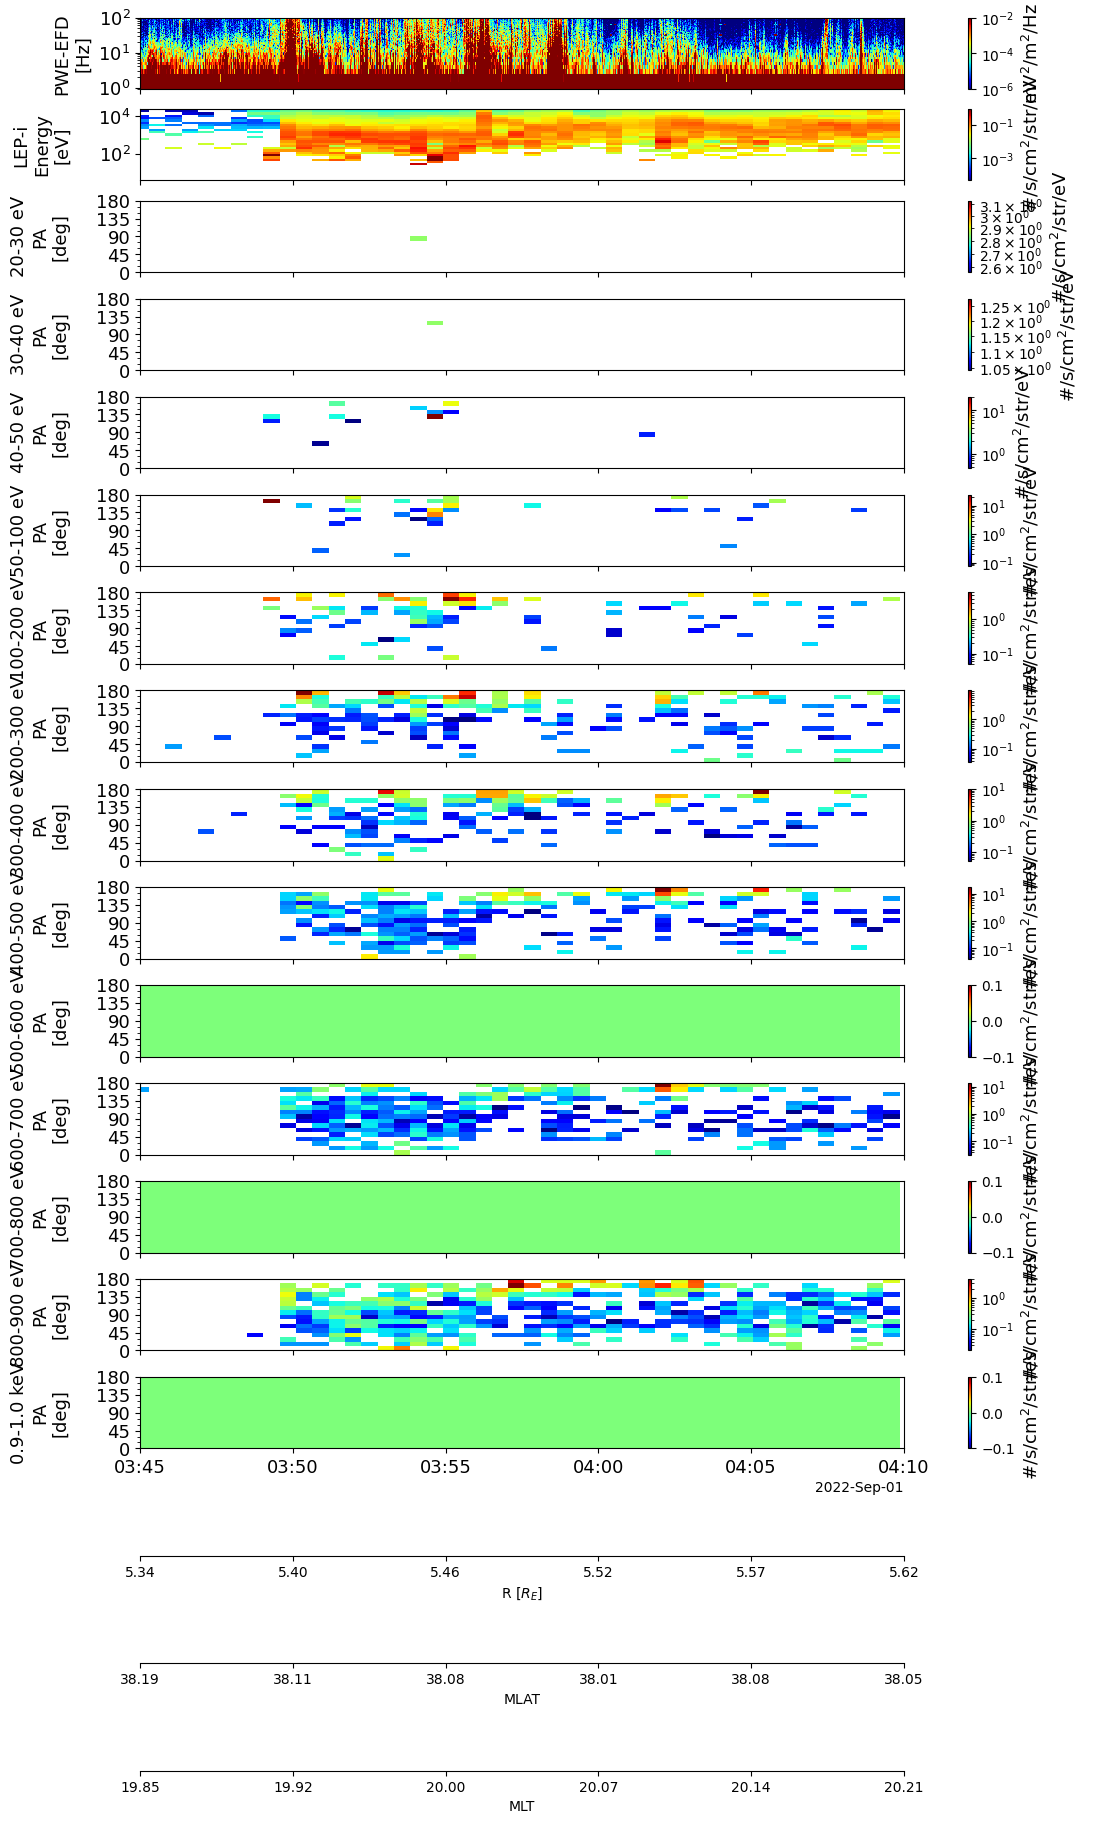

In [2]:
import pytplot as pt
import pyspedas as psp
import numpy as np

# ------------------------------------------------------------
# 基本設定 & データロード（ここはほぼそのまま）
# ------------------------------------------------------------
pt.del_data('*')
pt.timespan('2022-09-01/03:45:00', 25, keyword='minute')

trange = ['20220901/03:40:00', '20220901/04:20:00']
psp.erg.pwe_efd(trange, level='l2', datatype='spec')
psp.erg.lepi(trange, level='l2', datatype='3dflux')
psp.erg.mgf(trange, level='l2', datatype='64hz', coord='dsi')
psp.erg.orb(trange, level='l2', datatype='def')

# ------------------------------------------------------------
# 可変エネルギービン定義（eV 単位で揃える）
#  20-30 eV, 30-40 eV, 40-50 eV, 50-100 eV, ..., 400-500 eV
# ------------------------------------------------------------
bins_ev = [(k*10, (k+1)*10) for k in range(2, 5)] + [(50, 100)] + [(l*100, (l+1)*100) for l in range(1, 10)]

# ↓ tplot 変数名を自動生成
def make_name(lo, hi):
    unit = 'keV' if hi >= 1000 else 'eV'
    lo_u = lo//1000 if unit=='keV' else lo
    hi_u = hi//1000 if unit=='keV' else hi
    return f'erg_lepi_pa_{lo_u}-{hi_u}{unit}'

# ------------------------------------------------------------
# Figure サイズ & フォント一括設定
# ------------------------------------------------------------
panel_num  = len(bins_ev)          # +2 = PWE-EFD, Energy スペクトル
orbit_num  = 3                         # R, MLAT, MLT
inch_per   = 1.4                       # １パネル高さ
pt.tplot_options('xsize', 11)
pt.tplot_options('ysize', inch_per*(panel_num))
pt.tplot_options('vertical_spacing', 70)

# ------------------------------------------------------------
# PWE‐EFD と全エネルギー・スペクトルは先に用意
# ------------------------------------------------------------
psp.erg.erg_lep_part_products(
    'erg_lepi_l2_3dflux_FPDU', outputs='energy',
    mag_name='erg_mgf_l2_mag_64hz_dsi',
    pos_name='erg_orb_l2_pos_gse', trange=trange)

energy_flux = pt.data_quants['erg_lepi_l2_3dflux_FPDU_energy']
pt.store_data('erg_lepi_energy_eV', data={
    'x': energy_flux.time,
    'y': energy_flux.data * 1e-3,
    'v': energy_flux.spec_bins}, attr_dict=energy_flux.attrs)
pt.options('erg_lepi_energy_eV', 'ytitle', 'LEP-i\nEnergy\n[eV]')
pt.options('erg_lepi_energy_eV', 'ylog', 1)
pt.options('erg_lepi_energy_eV', 'ztitle', '#/s/cm^2/str/eV')
#pt.options('erg_lepi_energy_eV', 'zrange', [4e2, 1e8])

# ------------------------------------------------------------
# 各ピッチ角スペクトルをループで生成
# ------------------------------------------------------------
pa_vars = []            # プロット用変数名を貯める
for lo, hi in bins_ev:
    vname = make_name(lo, hi)
    # ① スペクトル生成
    psp.erg.erg_lep_part_products(
        'erg_lepi_l2_3dflux_FPDU', outputs='pa',
        energy=[lo, hi],
        mag_name='erg_mgf_l2_mag_64hz_dsi',
        pos_name='erg_orb_l2_pos_gse',
        trange=trange, suffix=f'_{lo}-{hi}')
    # ② tplot 変数へコピー
    src = pt.data_quants[f'erg_lepi_l2_3dflux_FPDU_pa_{lo}-{hi}']
    pt.store_data(vname, data={'x': src.time, 'y': src.data*1e-3,
                               'v': src.spec_bins}, attr_dict=src.attrs)
    # ③ 表示オプション
    lab_unit = 'keV' if hi >= 1000 else 'eV'
    pt.options(vname, 'ytitle',
               f'{lo/1000 if lab_unit=="keV" else lo}'
               f'-{hi/1000 if lab_unit=="keV" else hi} {lab_unit}\nPA\n[deg]')
    #pt.options(vname, 'zrange', [1e5, 1e8])
    pt.options(vname, 'y_major_ticks', [0, 45, 90, 135, 180])
    pt.options(vname, 'y_minor_tick_interval', 15)
    pt.options(vname, 'ztitle', '#/s/cm^2/str/eV')
    pa_vars.append(vname)


# ------------------------------------------------------------
# 軌道座標ラベル調整
# ------------------------------------------------------------
orb_labels = pt.split_vec('erg_orb_l2_pos_rmlatmlt')
for lbl, ttl in zip(orb_labels, [r'R [$R_E$]', 'MLAT', 'MLT']):
    pt.options(lbl, 'ytitle', ttl)
    pt.options(lbl, 'panel_size', 0.05)

# ------------------------------------------------------------
# PWE‐EFD の軸ラベル
# ------------------------------------------------------------
pt.options('erg_pwe_efd_l2_spec_spectra', 'ytitle', 'PWE-EFD')
pt.options('erg_pwe_efd_l2_spec_spectra', 'ztitle', 'mV$^2$/m$^2$/Hz')

# ------------------------------------------------------------
# 最終描画
# ------------------------------------------------------------

pt.tplot_options('axis_font_size', 13)
pt.tplot_options('title_size', 13)
pt.tplot_options('charsize', 13)

all_panels = ['erg_pwe_efd_l2_spec_spectra',
              'erg_lepi_energy_eV'] + pa_vars
pt.tplot(all_panels, var_label=orb_labels)


# ピッチ角分布のplot

In [ ]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
import pyspedas as psp, pytplot as pt, pandas as pd
from matplotlib.ticker import MultipleLocator

# ---- 時刻と trange ----
pt.del_data('*')

mpl.rcdefaults()


mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Computer Modern Roman']
mpl.rcParams['mathtext.fontset'] = 'cm'
font_size = 30
plt.rcParams["font.size"] = font_size

target = np.datetime64('2022-09-01T03:57:00')
dt     = np.timedelta64(30, 's')
str_t  = lambda t: str(t.astype('datetime64[s]')).replace('-', '').replace('T', '/')
trange = [str_t(target-dt), str_t(target+dt)]

# ---- データ ----
psp.erg.lepe(trange, datatype='3dflux', level='l2')                       # 3-D distribution
psp.erg.mgf(trange, datatype='64hz',  level='l2', coord='dsi')            # 磁場 (DSI)
psp.erg.orb(trange, datatype='def',   level='l2')                         # 衛星位置

lep_var = 'erg_lepi_l2_3dflux_FPDU'

flux = pt.data_quants['erg_lepi_l2_3dflux_FPDU']
energy_array = flux.v1[0, :]

# 最も近い時刻インデックス
tid = int(np.abs(pd.to_datetime(flux.time.values, unit='s')
                 - pd.to_datetime(str(target))).argmin())

fig, ax = plt.subplots(figsize=(10, 10))
norm = mpl.colors.LogNorm(vmin=np.nanmin(energy_array), vmax=5E3)
cmap = plt.cm.turbo
ax.set_xlim(0, 180)
ax.set_xlabel('Pitch Angle [deg]')
ax.xaxis.set_major_locator(MultipleLocator(30))
ax.set_yscale('log')
ax.set_ylabel(r'$\mathrm{H}^{+}$ flux [eV / s cm$^{2}$\,sr\,eV]')
ax.minorticks_on()
ax.grid(which='both', alpha=0.3)
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap=cmap), ax=ax, pad=0.02)
cb.set_label('Energy [eV]')


# pitch angle
for i, E in enumerate(energy_array):
    print(E.values)
    if ~np.isnan(E.values) and E.values < 5E3:
        psp.erg.erg_lep_part_products(lep_var, outputs='pa',
                                        trange=trange,
                                        energy=[np.floor(E.values), np.ceil(E.values)],
                                        mag_name='erg_mgf_l2_mag_64hz_dsi',
                                    pos_name='erg_orb_l2_pos_gse', suffix='_PA')
        flux_pitch = pt.data_quants['erg_lepe_l2_3dflux_FEDU_pa_PA'][tid, :] * E.values
        pitch_angle_array = flux_pitch.spec_bins.values

        print(pitch_angle_array)
        print("")
        print(flux_pitch)

        plt.title(flux.time.values[tid])
        plt.plot(pitch_angle_array, flux_pitch, color=cmap(norm(energy_array[i])))

fig.tight_layout()